In [2]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from collections import defaultdict
from functools import reduce
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse

from joblib import Parallel, delayed
from scipy.stats import multivariate_normal


In [3]:
rowwiseDfOriginal = pd.read_pickle("..\\data\\rowwiseDf.pkl")

model_bundle = joblib.load("../data/rowWiseModel/gmm_43_model.pkl")
scaler = model_bundle['scaler']
gmm = model_bundle['gmm']

cyclical= {'hour': 24, 'month': 12, 'day_of_year': 365}

MemoryError: 

In [333]:
df= rowwiseDfOriginal.drop(columns= ['MESS_DATUM', 'STATIONS_ID', 'RS_IND', 'WRTR','   P', '   D', 'Stationsname', 'hour', 'day', 'month'])

In [334]:
dataCol= df.columns

In [335]:
X = df.values

In [336]:
xScaled= scaler.transform(X)

In [ ]:
def RidgeRegression(targets: list, features: list, data: pd.DataFrame, syntheticData: pd.DataFrame):
    linearModels= {}
    realMse= []
    syntheticMse= []
    for target in targets:
        X= data[[f for f in features if f != target]]
        y= data[target]
        XSyn= syntheticData[[f for f in features if f != target]]
        ySyn= syntheticData[target]

        XTrain, XTest, yTrain, yTest= train_test_split(X, y, test_size=0.2, random_state=42)

        ridge= Ridge(alpha=1.0)
        ridge.fit(XTrain, yTrain)

        yPredReal= ridge.predict(XTest)
        yPredSyn= ridge.predict(XSyn)

        mseReal= mean_squared_error(yTest, yPredReal)
        mseSyn= mean_squared_error(ySyn, yPredSyn)
        realMse.append(mseReal)
        syntheticMse.append(mseSyn)

        print(f"Real Target: {target.strip()} - MSE: {mseReal}")
        print(f"Synthetic Target: {target.strip()} - MSE: {mseSyn}")

        linearModels[target.strip()]= ridge
    return linearModels, realMse, syntheticMse

In [338]:
def conditionalSampleGeneration(gmm: GaussianMixture, xCondRaw: list, idxCond: list, featureList: list, scaler, nSamples: int) -> list[list]:
    """
        Args:
        gmm: fitted GaussianMixture instance
        xCond: values to condition on (shape = [nFeaturesToCondition])
        idxCond: indices of conditioning features
        idxGen: indices of features to generate
        nSamples: number of samples to generate

    Returns:
        generated samples
    """

    dummyVector= np.zeros(len(featureList))
    dummyVector[idxCond] = xCondRaw
    dummyVectorScaled = scaler.transform([dummyVector])[0]
    xCond= dummyVectorScaled[idxCond]

    idxGen = [i for i, _ in enumerate(featureList) if i not in idxCond]

    samples = []
    weights = []

    for k in range(gmm.n_components):
        mean = gmm.means_[k]
        cov = gmm.covariances_[k]

        meanCond = mean[idxCond]
        meanGen = mean[idxGen]

        covCondCond = cov[idxCond][:, idxCond]
        covCondGen = cov[idxCond][:, idxGen]
        covGenCond = cov[idxGen][:, idxCond]
        covGenGen = cov[idxGen][:, idxGen]

        try:
            invCovCondCond = np.linalg.inv(covCondCond)
        except np.linalg.LinAlgError:
            invCovCondCond = np.linalg.pinv(covCondCond)

        condMean = meanGen + covGenCond @ invCovCondCond @ (xCond - meanCond)
        condCov = covGenGen - covGenCond @ invCovCondCond @ covCondGen

        p = multivariate_normal.pdf(xCond, mean=meanCond, cov=covCondCond)
        weights.append(gmm.weights_[k] * p)
        samples.append((condMean, condCov))

    weights = np.array(weights)
    weights /= weights.sum()

    chosen = np.random.choice(gmm.n_components, size=nSamples, p=weights)
    fullSamples = []
    for i in chosen:
        genPart = np.random.multivariate_normal(*samples[i])
        
        fullSample = np.zeros(len(featureList))
        fullSample[idxCond] = xCond  # Skaliert
        fullSample[idxGen] = genPart
        fullSamples.append(fullSample)

    return fullSamples


In [339]:
def dayConditions(day: int) -> list[list]:

    def dayToMonth(day: int) -> int:
        month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        cum_days = 0
        for i, days_in_month in enumerate(month_days):
            cum_days += days_in_month
            if day <= cum_days:
                return i + 1
    output= []
    cosMonth= np.cos(2 * np.pi * dayToMonth(day) / 12)
    sinMonth= np.sin(2 * np.pi * dayToMonth(day) / 24)
    cosDay= np.cos(2 * np.pi * day / 365)
    sinDay= np.sin(2 * np.pi * day / 365)

    for i in range(0, 24):
        hour= []
        hour.append(np.sin(2 * np.pi * i / 24))
        hour.append(np.cos(2 * np.pi * i / 24))
        hour.append(sinMonth)
        hour.append(cosMonth)
        hour.append(sinDay)
        hour.append(cosDay)

        output.append(hour)

    return output

In [340]:
def reconstruct_hour(hour_sin, hour_cos):
    angle = np.arctan2(hour_sin, hour_cos)
    angle = angle % (2 * np.pi)
    
    hour = int(round((angle / (2 * np.pi)) * 24)) % 24
    return hour

In [341]:
def inverse_cyclical(samples, cyclical= cyclical):
    results= samples.copy()
    for key, period in cyclical.items():
        sinCol = f"{key}_sin"
        cosCol = f"{key}_cos"

        sinVal= results[sinCol]
        cosVal= results[cosCol]
        
        angle = np.arctan2(sinVal, cosVal)
        angle = angle % (2 * np.pi)
        results[key] = angle * period / (2 * np.pi)

        results= results.drop(columns= [sinCol, cosCol])
    return results

In [342]:
def plot_pca_cluster_matrix(XPca, labels, gmm, pca, nComponents=5, sample_size= None):
    """
    Zeichnet eine nComponents x nComponents Scatterplot-Matrix mit GMM-Cluster-Ellipsen.
    
    XPca: PCA-transformierte Daten (n_samples, nComponents)
    labels: Cluster-Zugehörigkeiten (z.B. von gmm.predict_proba)
    gmm: trainiertes GMM-Modell
    pca: trainiertes PCA-Modell
    nComponents: Anzahl PCA-Komponenten (empfohlen: <=5)
    sample_size: Begrenzung der Punktzahl für Performance
    """
    if sample_size is not None and len(XPca) > sample_size:
        idx = np.random.choice(len(XPca), size=sample_size, replace=False)
        XPca = XPca[idx]
        labels = labels[idx]


    nClusters = len(gmm.means_)
    cmap = plt.cm.get_cmap('tab20', nClusters)

    fig, axes = plt.subplots(nComponents, nComponents, figsize=(3 * nComponents, 3 * nComponents),
                             constrained_layout=True)

    meansPca = pca.transform(gmm.means_)

    for i in range(nComponents):
        for j in range(nComponents):
            ax = axes[i, j]

            if i == j:
                ax.axis("off")
                continue

            ax.scatter(XPca[:, j], XPca[:, i], c=labels, cmap=cmap, s=8, alpha=0.6)

            # Ellipsen in der richtigen 2D-Ebene
            for k in range(nClusters):
                cov = gmm.covariances_[k]
                if cov.ndim == 3:
                    cov_k = cov
                else:
                    cov_k = np.array([cov] * nClusters)

                # Transformiere die kovarianz auf PCA-Raum, dann 2D-Ausschnitt holen
                covPca = pca.components_ @ cov_k[k] @ pca.components_.T
                cov2D = covPca[[j, i]][:, [j, i]]

                if cov2D.shape != (2, 2):
                    continue

                U, s, _ = np.linalg.svd(cov2D)
                angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
                width, height = 2 * np.sqrt(s)

                ell = Ellipse(
                    xy=(meansPca[k, j], meansPca[k, i]),
                    width=width,
                    height=height,
                    angle=angle,
                    edgecolor=cmap(k),
                    facecolor='none',
                    linewidth=1.5,
                    linestyle='--',
                    alpha=0.5
                )
                ax.add_patch(ell)

            if i == nComponents - 1:
                ax.set_xlabel(f"PCA {j+1}")
            else:
                ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(f"PCA {i+1}")
            else:
                ax.set_yticks([])

    plt.suptitle("PCA-Cluster-Matrix mit GMM-Ellipsen", fontsize=16)
    plt.show()


In [343]:
def plot_feature_cluster_matrix(data_df: pd.DataFrame, labels: np.ndarray, gmm, sample_size=5000):
    """
    Zeichnet eine Scatterplot-Matrix für die echten (nicht PCA) Features mit GMM-Ellipsen.
    
    Parameters:
    - data_df: DataFrame mit den ursprünglichen (rekonstruierten) Features
    - labels: Array mit Cluster-Zugehörigkeiten (z.B. von GMM)
    - gmm: das trainierte GMM-Modell (für means_ und covariances_)
    - sample_size: maximale Anzahl an Punkten für die Darstellung
    """
    # Sampling
    if len(data_df) > sample_size:
        idx = np.random.choice(data_df.index, size=sample_size, replace=False)
        data_df = data_df.loc[idx].reset_index(drop=True)
        labels = labels[data_df.index]
    else:
        data_df = data_df.reset_index(drop=True)

    features = data_df.columns
    n_features = len(features)
    n_clusters = len(gmm.means_)
    cmap = plt.cm.get_cmap("tab20", n_clusters)

    fig, axes = plt.subplots(n_features, n_features, figsize=(3 * n_features, 3 * n_features),
                             constrained_layout=True)

    for i in range(n_features):
        for j in range(n_features):
            ax = axes[i, j]

            if i == j:
                ax.hist(data_df.iloc[:, i], bins=30, color="gray", alpha=0.6)
                ax.set_yticks([])
            else:
                ax.scatter(data_df.iloc[:, j], data_df.iloc[:, i],
                           c=labels, cmap=cmap, s=10, alpha=0.5)

                # GMM-Ellipsen
                for k in range(n_clusters):
                    cov = gmm.covariances_[k]
                    if cov.ndim == 3:
                        cov_k = cov[k][[j, i]][:, [j, i]]
                    else:
                        cov_k = np.array([[cov[j, j], cov[j, i]],
                                          [cov[i, j], cov[i, i]]])

                    if cov_k.shape != (2, 2):
                        continue

                    mean = gmm.means_[k][[j, i]]
                    U, s, _ = np.linalg.svd(cov_k)
                    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
                    width, height = 2 * np.sqrt(s)

                    ell = Ellipse(xy=mean,
                                  width=width,
                                  height=height,
                                  angle=angle,
                                  edgecolor=cmap(k),
                                  facecolor="none",
                                  linestyle="--",
                                  linewidth=1.5,
                                  alpha=0.5)
                    ax.add_patch(ell)

            if i == n_features - 1:
                ax.set_xlabel(features[j])
            else:
                ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(features[i])
            else:
                ax.set_yticks([])

    plt.suptitle("Feature-Cluster-Matrix mit GMM-Ellipsen", fontsize=16)
    plt.show()

In [344]:
def plot_real_feature_distributions(real_df, features, bins=30):
    """
    Zeichnet für jedes angegebene Feature ein Histogramm:
    - Echt (real_df) vs. Generiert (samples)
    
    Parameter:
    - real_df: DataFrame mit echten Daten
    - samples: DataFrame mit generierten Daten
    - features: Liste der Spaltennamen (Features), die geplottet werden sollen
    - bins: Anzahl der Bins im Histogramm
    """
    n = len(features)
    ncols = 2
    nrows = (n + 1) // ncols

    plt.figure(figsize=(ncols * 6, nrows * 4))
    
    for idx, feature in enumerate(features):
        plt.subplot(nrows, ncols, idx + 1)
        sns.histplot(real_df[feature], bins=bins, color='blue', label='Real', stat='density', alpha=0.5)
        plt.title(f"Verteilung: {feature}")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [345]:
def plot_feature_distributions(real_df, samples, features, bins=30):
    """
    Zeichnet für jedes angegebene Feature ein Histogramm:
    - Echt (real_df) vs. Generiert (samples)
    
    Parameter:
    - real_df: DataFrame mit echten Daten
    - samples: DataFrame mit generierten Daten
    - features: Liste der Spaltennamen (Features), die geplottet werden sollen
    - bins: Anzahl der Bins im Histogramm
    """
    n = len(features)
    ncols = 2
    nrows = (n + 1) // ncols

    plt.figure(figsize=(ncols * 6, nrows * 4))
    
    for idx, feature in enumerate(features):
        plt.subplot(nrows, ncols, idx + 1)
        sns.histplot(real_df[feature], bins=bins, color='blue', label='Real', stat='density', alpha=0.5)
        sns.histplot(samples[feature], bins=bins, color='orange', label='Generated', stat='density', alpha=0.5)
        plt.title(f"Verteilung: {feature}")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [346]:
#Total Data Evaluation

In [347]:
#Linear Regression Targets and Features
features= dataCol
targets= ['TT_TU', 'RF_TU', '  R1', '  P0', '   F']

sampleSize= 10000

In [348]:
samples, _ = gmm.sample(sampleSize)
samplesOriginal = scaler.inverse_transform(samples)

In [349]:
realCyclic_df = pd.DataFrame(X, columns= dataCol)
fakeCyclic_df = pd.DataFrame(samplesOriginal, columns= dataCol)

In [350]:
fake_df= inverse_cyclical(fakeCyclic_df)
real_df= inverse_cyclical(realCyclic_df)

In [351]:
comparison = pd.DataFrame({
    'mean_real': real_df.mean(),
    'mean_fake': fake_df.mean(),
    'std_real': real_df.std(),
    'std_fake': fake_df.std(),
    'max_real': real_df.max(),
    'max_fake': fake_df.max(),
    'min_real': real_df.min(),
    'min_fake': fake_df.min()
})
print(comparison)

                mean_real   mean_fake    std_real    std_fake   max_real  \
TT_TU            9.207244    9.202075    7.917143    7.961411    38.6000   
RF_TU           77.639356   77.708400   17.792289   17.761584   100.0000   
  R1             0.080793    0.089766    0.497182    0.516588    50.8000   
  P0           964.639864  964.726965   27.937734   28.060154  1027.0000   
   F             3.507386    3.472963    2.170473    2.165144    23.9000   
Stationshoehe  438.736842  438.303188  231.551551  231.767437   938.0000   
geoBreite       50.956547   50.959095    0.483383    0.482239    51.8454   
geoLaenge       10.957000   10.944671    0.734970    0.727458    12.1300   
hour            11.500000   11.915257    6.922189    6.950289    23.0000   
month            6.523549    6.005950    3.448534    3.479484    12.0000   
day_of_year    181.900876  182.745077  105.422286  105.090432   364.0000   

                  max_fake      min_real    min_fake  
TT_TU            38.003936 -2.34

In [352]:
dfScaled= pd.DataFrame(xScaled, columns= dataCol)
synDf= pd.DataFrame(samples, columns= dataCol)
synDfOriginal= pd.DataFrame(samplesOriginal, columns= dataCol)

In [353]:
dfScaledSampled = realCyclic_df.sample(n=sampleSize, replace=False, random_state= 42)

In [354]:
dfScaledSampled.columns

Index(['TT_TU', 'RF_TU', '  R1', '  P0', '   F', 'Stationshoehe', 'geoBreite',
       'geoLaenge', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'day_of_year_sin', 'day_of_year_cos'],
      dtype='object')

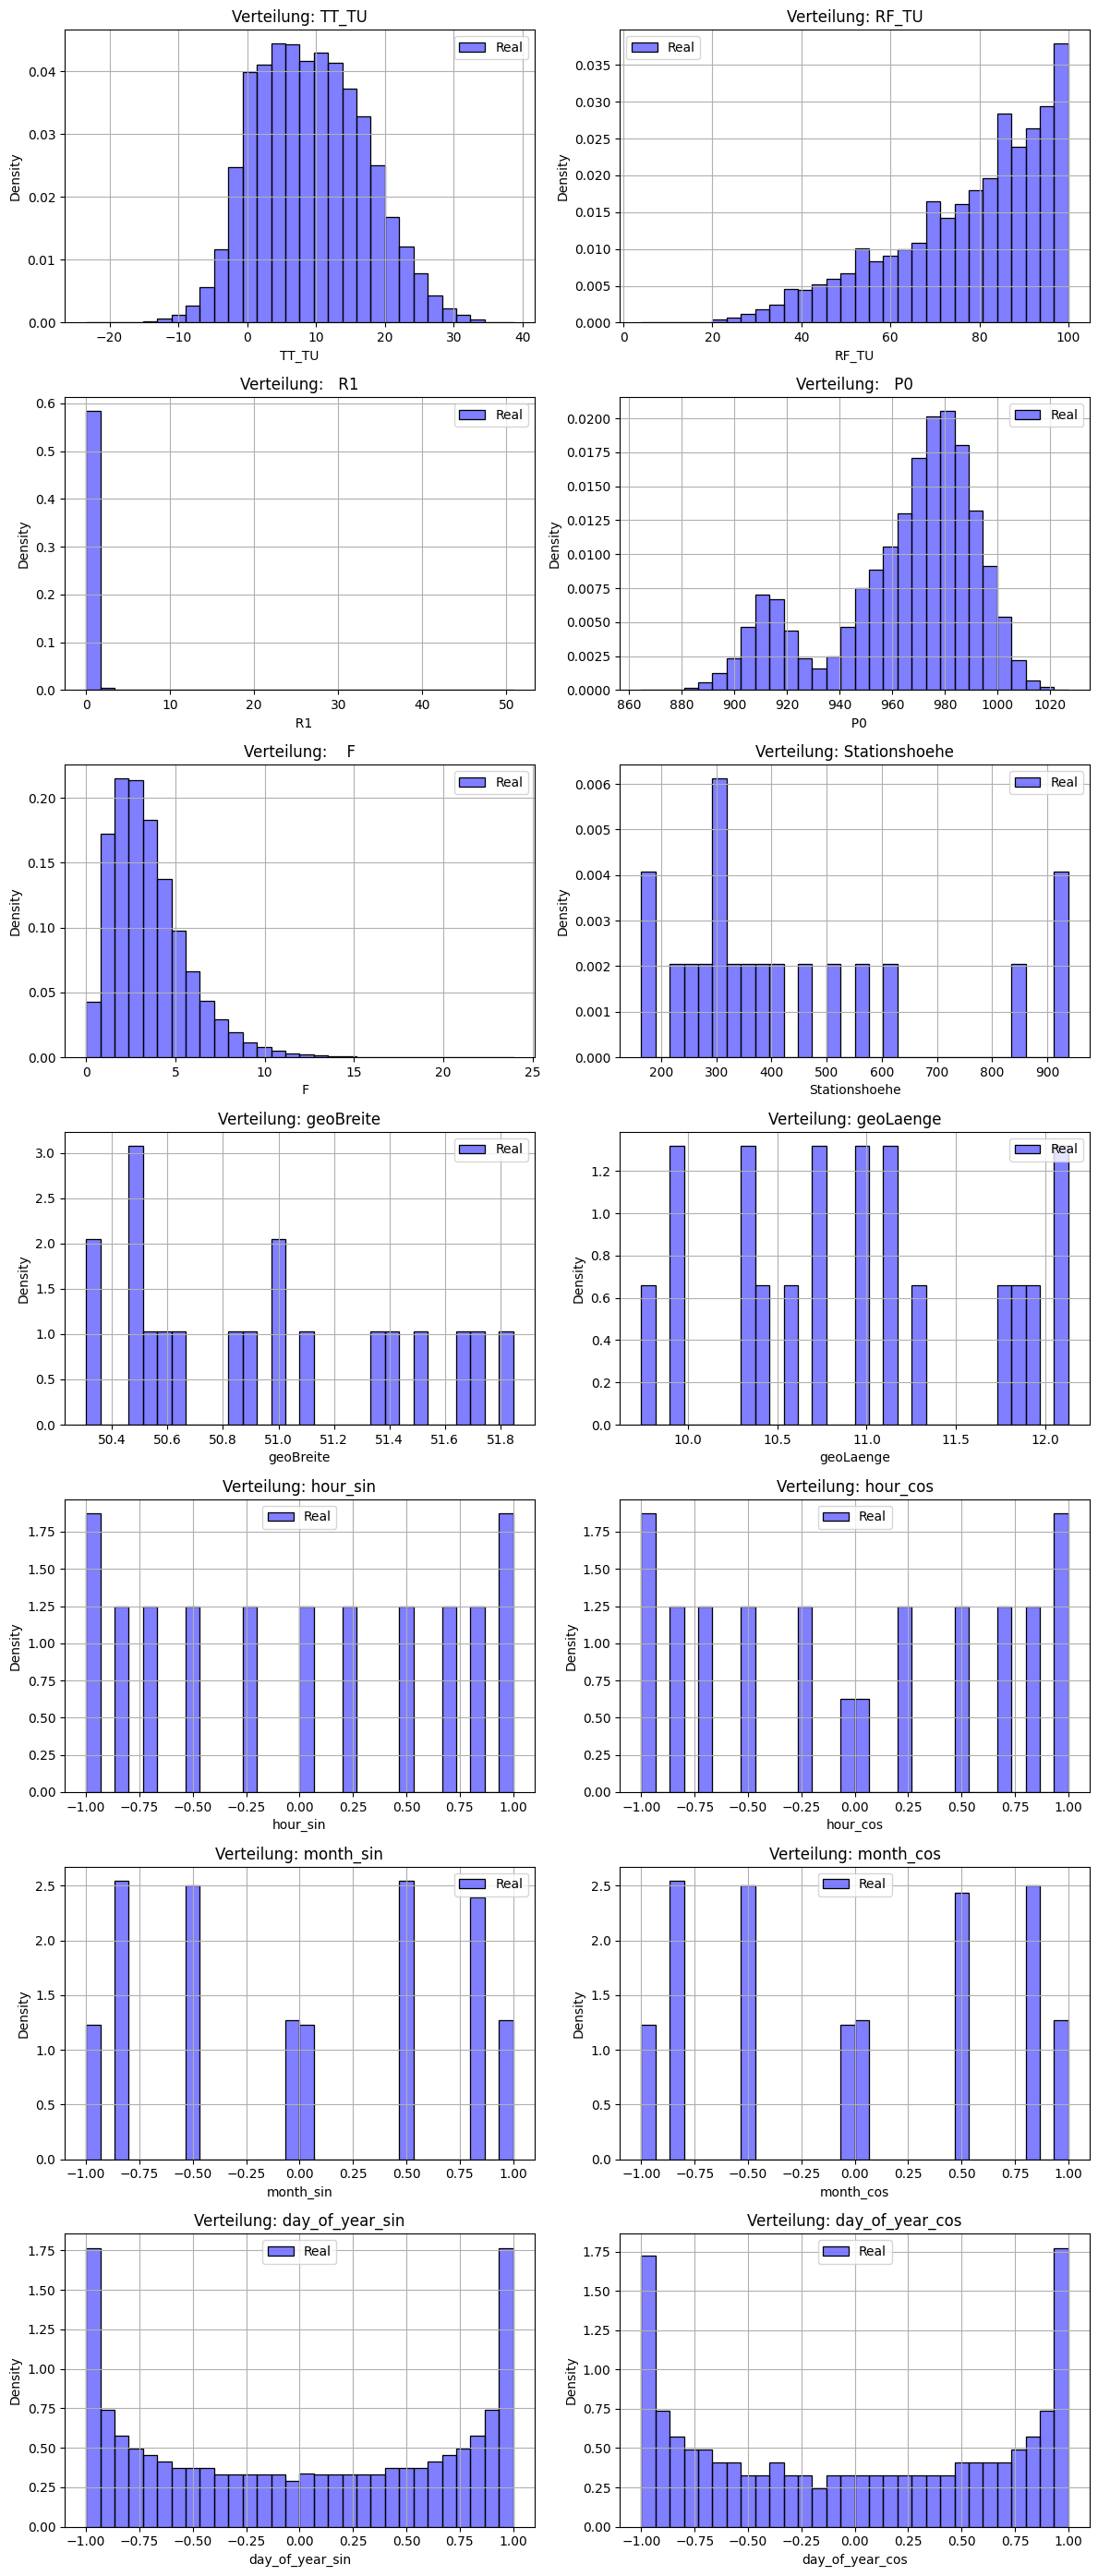

In [355]:
plot_real_feature_distributions(df, df.columns)

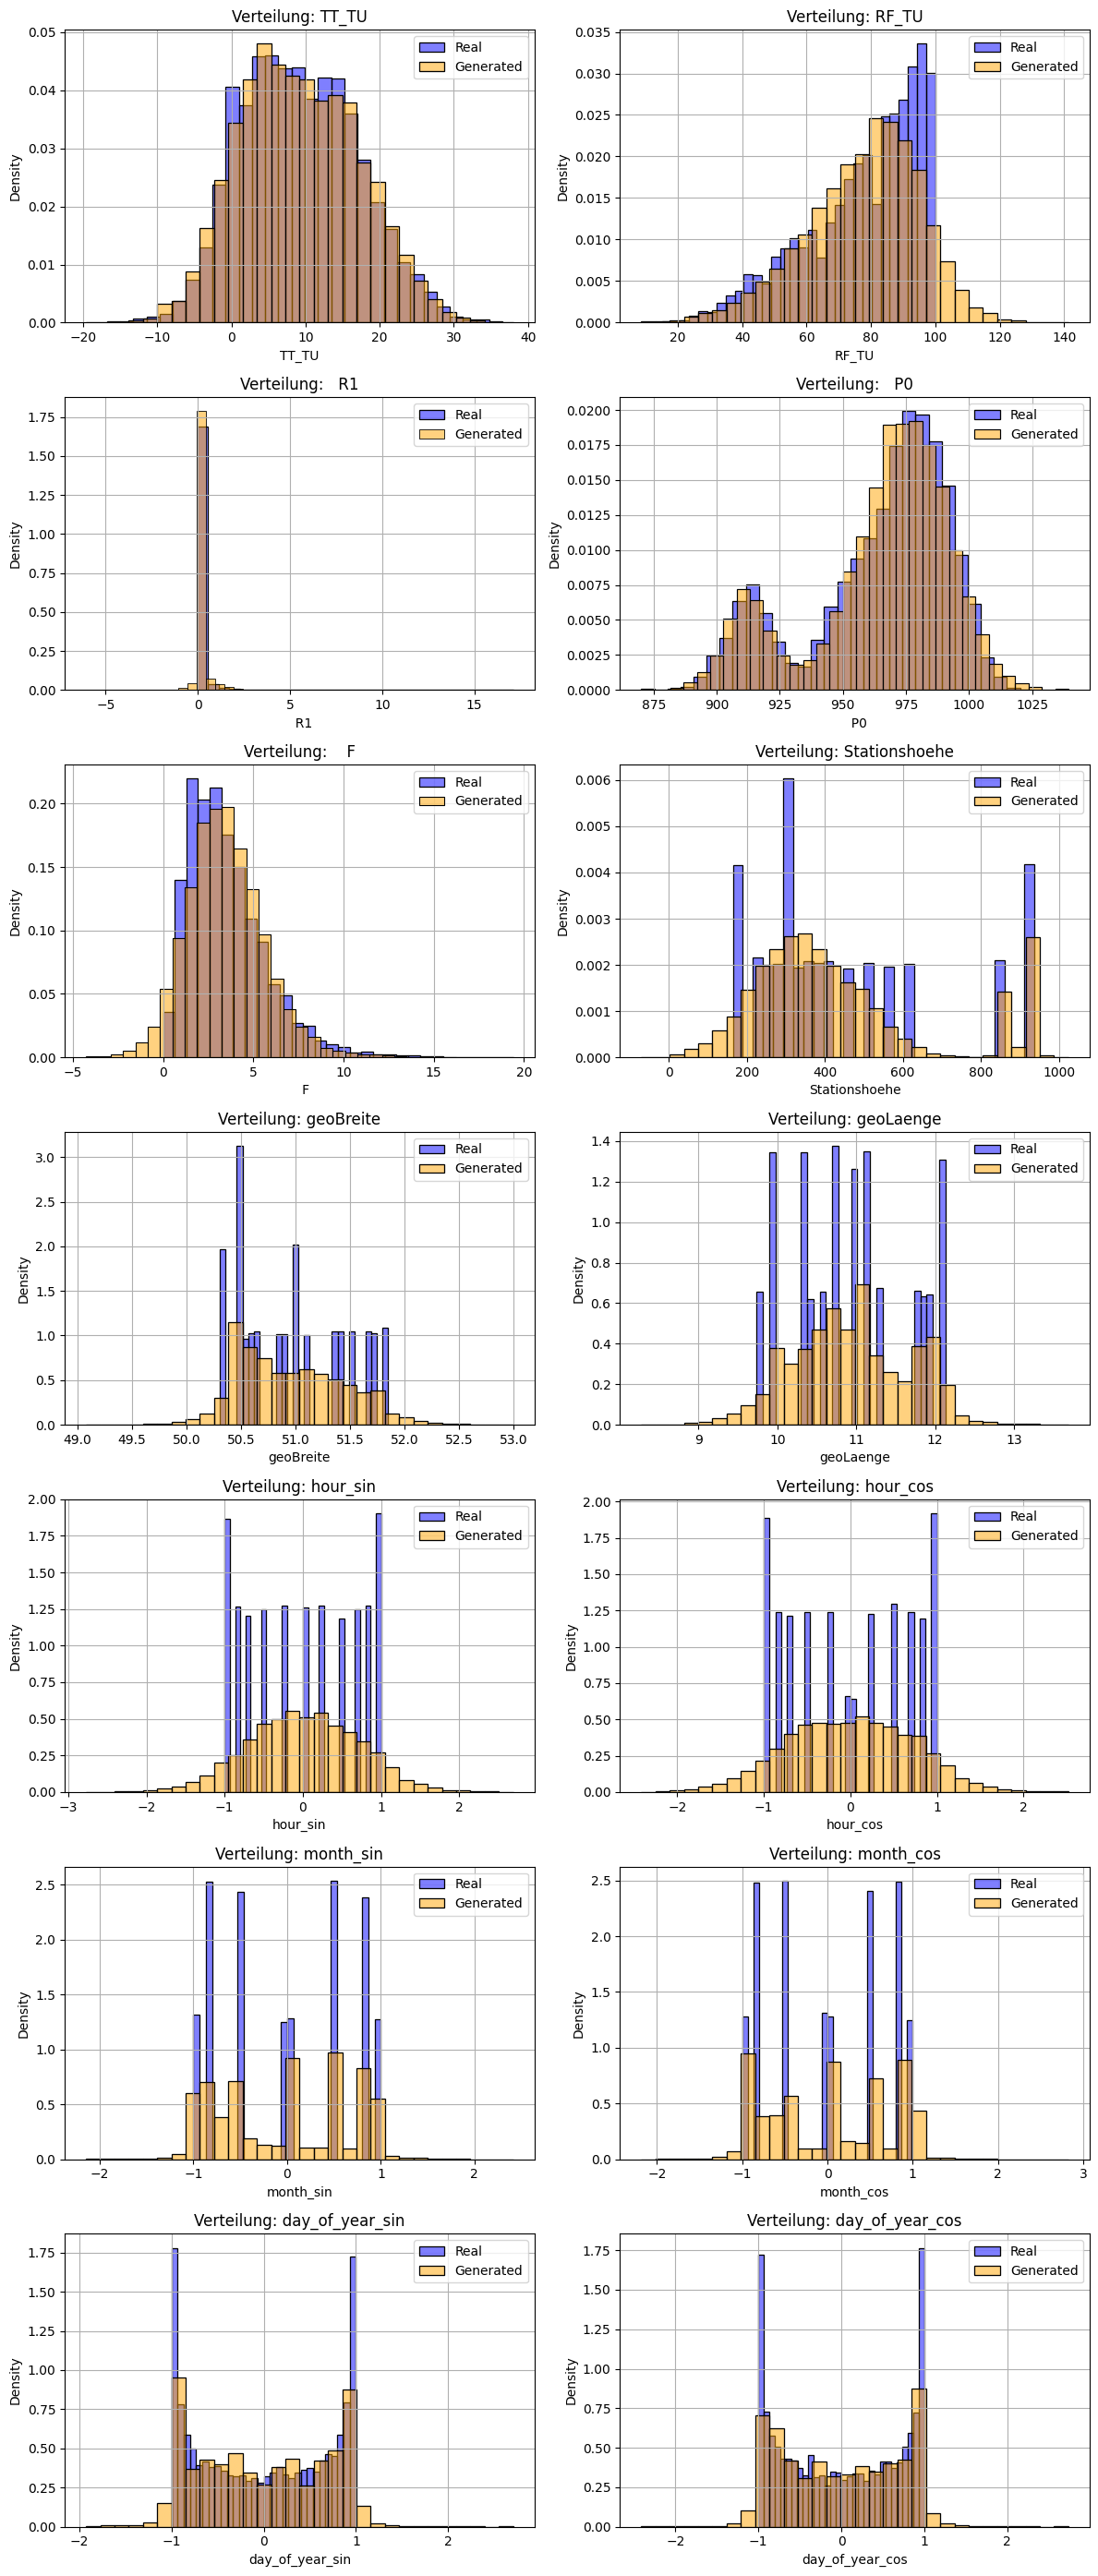

In [356]:
plot_feature_distributions(dfScaledSampled, synDfOriginal, synDfOriginal.columns)

In [357]:
linearModels, realMse, syntheticMse= OLSRegression(['TT_TU', 'RF_TU', '  R1', '  P0', '   F', 'Stationshoehe', 'geoBreite', 'geoLaenge'], dataCol, df, synDfOriginal)

Real Target: TT_TU - MSE: 13.372331639378459
Synthetic Target: TT_TU - MSE: 13.38633409242263
Real Target: RF_TU - MSE: 143.00895276933375
Synthetic Target: RF_TU - MSE: 142.44571773229902
Real Target: R1 - MSE: 0.2437917452427215
Synthetic Target: R1 - MSE: 0.2521241311527952
Real Target: P0 - MSE: 65.02186831031752
Synthetic Target: P0 - MSE: 65.82985448093262
Real Target: F - MSE: 3.582034902189935
Synthetic Target: F - MSE: 3.623370570698123
Real Target: Stationshoehe - MSE: 4442.127266073264
Synthetic Target: Stationshoehe - MSE: 4461.8984703427195
Real Target: geoBreite - MSE: 0.1655140520827747
Synthetic Target: geoBreite - MSE: 0.1662550306338875
Real Target: geoLaenge - MSE: 0.4775935422619491
Synthetic Target: geoLaenge - MSE: 0.4747209429213444


In [358]:
features = ['TT_TU', 'RF_TU', 'R1', 'P0', 'F', 'Stationshoehe', 'geoBreite', 'geoLaenge']

mseComparer = pd.DataFrame({
    'Feature': features,
    'MSE_Real': realMse,
    'MSE_Synthetic': syntheticMse,
})
mseComparer["Delta (%)"] = 100 * (mseComparer["MSE_Synthetic"] - mseComparer["MSE_Real"]) / mseComparer["MSE_Real"]

print(mseComparer.round(4))

         Feature   MSE_Real  MSE_Synthetic  Delta (%)
0          TT_TU    13.3723        13.3863     0.1047
1          RF_TU   143.0090       142.4457    -0.3938
2             R1     0.2438         0.2521     3.4178
3             P0    65.0219        65.8299     1.2426
4              F     3.5820         3.6234     1.1540
5  Stationshoehe  4442.1273      4461.8985     0.4451
6      geoBreite     0.1655         0.1663     0.4477
7      geoLaenge     0.4776         0.4747    -0.6015


In [359]:
linearModels, realMse, syntheticMse= OLSRegression(['TT_TU', 'RF_TU', '  R1', '  P0', '   F', 'Stationshoehe', 'geoBreite', 'geoLaenge'], dataCol, dfScaled, synDf)

Real Target: TT_TU - MSE: 0.21333908093020804
Synthetic Target: TT_TU - MSE: 0.21356250934327317
Real Target: RF_TU - MSE: 0.451751758801214
Synthetic Target: RF_TU - MSE: 0.44997254258771324
Real Target: R1 - MSE: 0.9862544769312943
Synthetic Target: R1 - MSE: 1.019962974971873
Real Target: P0 - MSE: 0.08330620620023495
Synthetic Target: P0 - MSE: 0.0843414061181968
Real Target: F - MSE: 0.7603637974980307
Synthetic Target: F - MSE: 0.7691381145926023
Real Target: Stationshoehe - MSE: 0.08285064019365243
Synthetic Target: Stationshoehe - MSE: 0.08321939020182476
Real Target: geoBreite - MSE: 0.7083572102012428
Synthetic Target: geoBreite - MSE: 0.7115284101991712
Real Target: geoLaenge - MSE: 0.8841362265110035
Synthetic Target: geoLaenge - MSE: 0.8788184091614935


In [360]:
features = ['TT_TU', 'RF_TU', 'R1', 'P0', 'F', 'Stationshoehe', 'geoBreite', 'geoLaenge']

mseComparer = pd.DataFrame({
    'Feature': features,
    'MSE_Real': realMse,
    'MSE_Synthetic': syntheticMse,
})
mseComparer["Delta (%)"] = 100 * (mseComparer["MSE_Synthetic"] - mseComparer["MSE_Real"]) / mseComparer["MSE_Real"]

print(mseComparer.round(4))

         Feature  MSE_Real  MSE_Synthetic  Delta (%)
0          TT_TU    0.2133         0.2136     0.1047
1          RF_TU    0.4518         0.4500    -0.3938
2             R1    0.9863         1.0200     3.4178
3             P0    0.0833         0.0843     1.2426
4              F    0.7604         0.7691     1.1540
5  Stationshoehe    0.0829         0.0832     0.4451
6      geoBreite    0.7084         0.7115     0.4477
7      geoLaenge    0.8841         0.8788    -0.6015


In [330]:
labels = gmm.predict(xScaled)

idx = np.random.choice(len(X), size=100000, replace=False)
score = silhouette_score(X[idx], labels[idx])
print(f"Silhouette Score (100k sample): {score:.4f}")
#Werte Nahe 1 gute getrennte Cluster, Nahe 0 Überlappende Cluster, Nahe -1 Fasche Clusterzuweisungen

Silhouette Score (100k sample): -0.2893


In [113]:
#Location Conditional Evaluation

In [114]:
#Linear Regression Targets and Features
features= dataCol
targets= ['TT_TU', 'RF_TU', '  R1', '  P0', '   F']

#Conditional Generation
nSamples= 1000
condValues= [316, 50.9829, 10.9608]
idxCond= [5, 6, 7]

In [115]:
samples= conditionalSampleGeneration(gmm, condValues, idxCond, dataCol, scaler, nSamples)

In [116]:
samplesOriginal = scaler.inverse_transform(samples)

In [117]:
tmp = pd.DataFrame(X, columns= dataCol)
realCyclic_df = tmp[(tmp['Stationshoehe'] == condValues[0]) & (tmp['geoBreite'].sub(condValues[1]).abs() < 1e-4) & (tmp['geoLaenge'].sub(condValues[2]).abs() < 1e-4)]
fakeCyclic_df = pd.DataFrame(samplesOriginal, columns= dataCol)

In [118]:
fake_df= inverse_cyclical(fakeCyclic_df)
real_df= inverse_cyclical(realCyclic_df)

In [119]:
comparison = pd.DataFrame({
    'mean_real': real_df.mean(),
    'mean_fake': fake_df.mean(),
    'std_real': real_df.std(),
    'std_fake': fake_df.std(),
    'max_real': real_df.max(),
    'max_fake': fake_df.max(),
    'min_real': real_df.min(),
    'min_fake': fake_df.min()
})

print(comparison)

                mean_real   mean_fake      std_real      std_fake   max_real  \
TT_TU            9.964315    9.950424  7.902395e+00  7.719198e+00    37.3000   
RF_TU           76.121885   76.404148  1.719759e+01  1.747590e+01   100.0000   
  R1             0.055078    0.086441  4.708126e-01  5.735165e-01    34.3000   
  P0           978.135702  978.704591  8.728157e+00  9.194398e+00  1007.6000   
   F             4.209897    3.298063  2.452403e+00  1.924061e+00    22.5000   
Stationshoehe  316.000000  316.000000  0.000000e+00  0.000000e+00   316.0000   
geoBreite       50.982900   50.982900  2.131640e-14  1.421797e-14    50.9829   
geoLaenge       10.960800   10.960800  3.552734e-15  3.554491e-15    10.9608   
hour            11.500000   12.418884  6.922226e+00  6.945705e+00    23.0000   
month            6.523549    6.316804  3.448553e+00  3.470727e+00    12.0000   
day_of_year    181.900876  187.387470  1.054229e+02  1.038925e+02   364.0000   

                  max_fake      min_rea

In [120]:
dfScaled= pd.DataFrame(xScaled, columns= dataCol)
synDf= pd.DataFrame(samples, columns= dataCol)
synDfOriginal= pd.DataFrame(samplesOriginal, columns= dataCol)

In [121]:
dfSampled = realCyclic_df.sample(n=nSamples, replace=False, random_state= 42)

In [122]:
dfSampled.columns

Index(['TT_TU', 'RF_TU', '  R1', '  P0', '   F', 'Stationshoehe', 'geoBreite',
       'geoLaenge', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'day_of_year_sin', 'day_of_year_cos'],
      dtype='object')

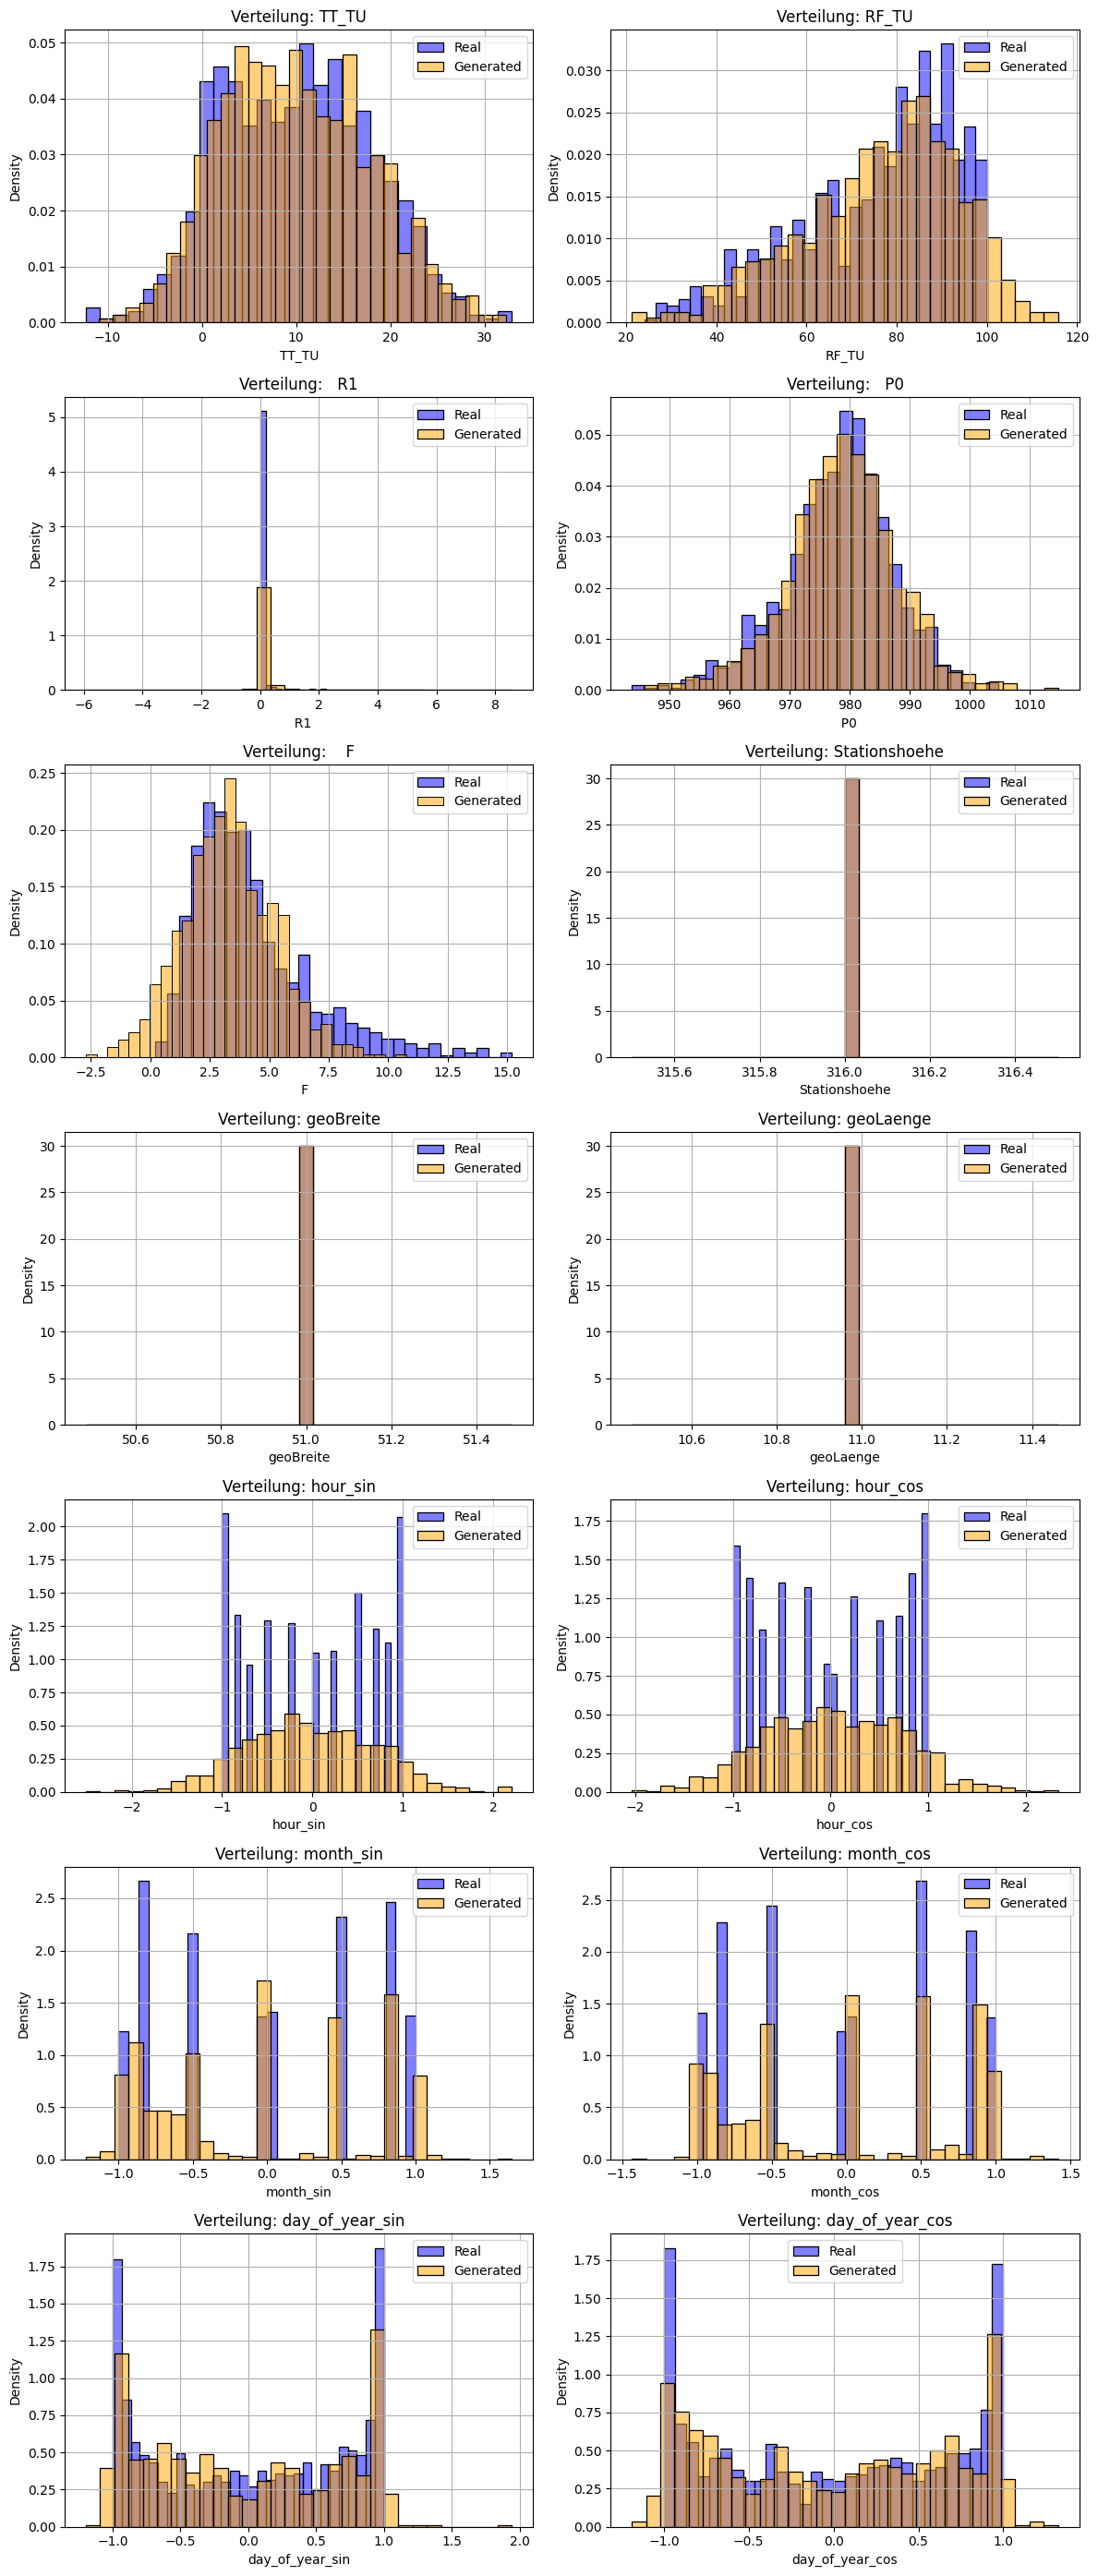

In [123]:
plot_feature_distributions(dfSampled, synDfOriginal, synDfOriginal.columns)

In [124]:
linearModels= OLSRegression(['TT_TU', 'RF_TU', '  R1', '  P0', '   F'], dataCol, dfScaled, synDf)

Real Target: TT_TU - MSE: 0.21333908093020804
Synthetic Target: TT_TU - MSE: 0.189523323548769
Real Target: RF_TU - MSE: 0.451751758801214
Synthetic Target: RF_TU - MSE: 0.40729722574568733
Real Target: R1 - MSE: 0.9862544769312943
Synthetic Target: R1 - MSE: 1.2785797351204413
Real Target: P0 - MSE: 0.08330620620023495
Synthetic Target: P0 - MSE: 0.0953223165361419
Real Target: F - MSE: 0.7603637974980307
Synthetic Target: F - MSE: 0.6309423636576647


In [125]:
#Timesieres Evaluation (Temporal Conditional Evaluation)

In [126]:
#Linear Regression Targets and Features
features= dataCol
targets= ['TT_TU', 'RF_TU', '  R1', '  P0', '   F']

# Conditional Temporal Generation
day= 210
idxDay= [8, 9, 10, 11, 12, 13]
nSamples= 10
condValues= [316, 50.9829, 10.9608]
idxCond= [5, 6, 7]

nYears = 10
hoursPerDay = 24

In [127]:
dayCondList = dayConditions(day)
tmpValues = condValues
tmpIdx = idxCond

condValuesList = []
idxCondList = []

for dayCond in dayCondList:
    condValues = []
    idxCond = []

    for i in range(len(features)):
        if i in tmpIdx:
            idx = tmpIdx.index(i)
            condValues.append(tmpValues[idx])
            idxCond.append(i)

        elif i in idxDay:
            idx = idxDay.index(i)
            condValues.append(dayCond[idx])
            idxCond.append(i)

    condValuesList.append(condValues)
    idxCondList.append(idxCond)     

In [128]:
samples= []
for i in range(len(idxCondList)):
    samples.append(conditionalSampleGeneration(gmm, condValuesList[i], idxCondList[i], dataCol, scaler, nSamples))

samples = np.vstack(samples)    

In [129]:
samplesOriginal= scaler.inverse_transform(samples)

In [130]:
tmp = pd.DataFrame(X, columns= dataCol)
realCyclic_df = tmp[(tmp['Stationshoehe'] == condValues[0]) & (tmp['geoBreite'].sub(condValues[1]).abs() < 1e-4) & (tmp['geoLaenge'].sub(condValues[2]).abs() < 1e-4) & (tmp['day_of_year_cos'].sub(np.cos(2 * np.pi * day / 365)).abs() < 1e-4) & (tmp['day_of_year_sin'].sub(np.sin(2 * np.pi * day / 365)).abs() < 1e-4)]
fakeCyclic_df = pd.DataFrame(samplesOriginal, columns= dataCol)

In [131]:
fake_df= inverse_cyclical(fakeCyclic_df)
real_df= inverse_cyclical(realCyclic_df)

In [132]:
comparison = pd.DataFrame({
    'mean_real': real_df.mean(),
    'mean_fake': fake_df.mean(),
    'std_real': real_df.std(),
    'std_fake': fake_df.std(),
    'max_real': real_df.max(),
    'max_fake': fake_df.max(),
    'min_real': real_df.min(),
    'min_fake': fake_df.min()
})

print(comparison)

                mean_real   mean_fake      std_real      std_fake  max_real  \
TT_TU           19.598750   -1.025991  3.839047e+00  3.594509e+00   29.0000   
RF_TU           68.083333   93.473851  1.713841e+01  6.351596e+00   97.0000   
  R1             0.077917    0.349932  8.159830e-01  4.009091e-01   12.3000   
  P0           974.750417  962.721754  3.123631e+00  1.034681e+01  980.4000   
   F             4.517500    1.354971  1.967377e+00  2.344850e+00    9.9000   
Stationshoehe  316.000000  316.000000  0.000000e+00  0.000000e+00  316.0000   
geoBreite       50.982900   50.982900  1.424055e-14  1.424055e-14   50.9829   
geoLaenge       10.960800   10.960800  3.560138e-15  3.560138e-15   10.9608   
hour            11.500000   11.500000  6.936653e+00  6.936653e+00   23.0000   
month            7.000000    4.395954  0.000000e+00  8.900346e-16    7.0000   
day_of_year    210.000000  210.000000  0.000000e+00  0.000000e+00  210.0000   

                 max_fake  min_real    min_fake  
T

In [133]:
real_df= real_df.copy()
real_df['Year'] = np.repeat(np.arange(nYears), hoursPerDay)

In [134]:
real_df

TT_TU  RF_TU    R1     P0     F  Stationshoehe  geoBreite  geoLaenge  \
443256   18.0   84.0  12.3  973.0   3.9          316.0    50.9829    10.9608   
443257   17.0   94.0   0.0  972.9   2.5          316.0    50.9829    10.9608   
443258   17.1   96.0   0.1  972.4   2.5          316.0    50.9829    10.9608   
443259   17.2   96.0   0.0  972.2   1.3          316.0    50.9829    10.9608   
443260   17.0   97.0   0.0  972.0   1.1          316.0    50.9829    10.9608   
...       ...    ...   ...    ...   ...            ...        ...        ...   
522163   19.2   76.0   0.0  972.0   5.1          316.0    50.9829    10.9608   
522164   17.3   83.0   0.0  972.6   3.8          316.0    50.9829    10.9608   
522165   17.0   85.0   0.0  972.7   3.5          316.0    50.9829    10.9608   
522166   16.4   88.0   0.0  972.6   3.0          316.0    50.9829    10.9608   
522167   15.8   91.0   0.0  972.8   2.9          316.0    50.9829    10.9608   

        hour  month  day_of_year  Year  
443256   0.0    7.0        210.0     0  
443257   1.0    7.0        210.0     0  
443258   2.0    7.0        210.0     0  
443259   3.0    7.0        210.0     0  
443260   4.0    7.0        210.0     0  
...      ...    ...          ...   ...  
522163  19.0    7.0        210.0     9  
522164  20.0    7.0        210.0     9  
522165  21.0    7.0        210.0     9  
522166  22.0    7.0        210.0     9  
522167  23.0    7.0        210.0     9  

[240 rows x 12 columns]

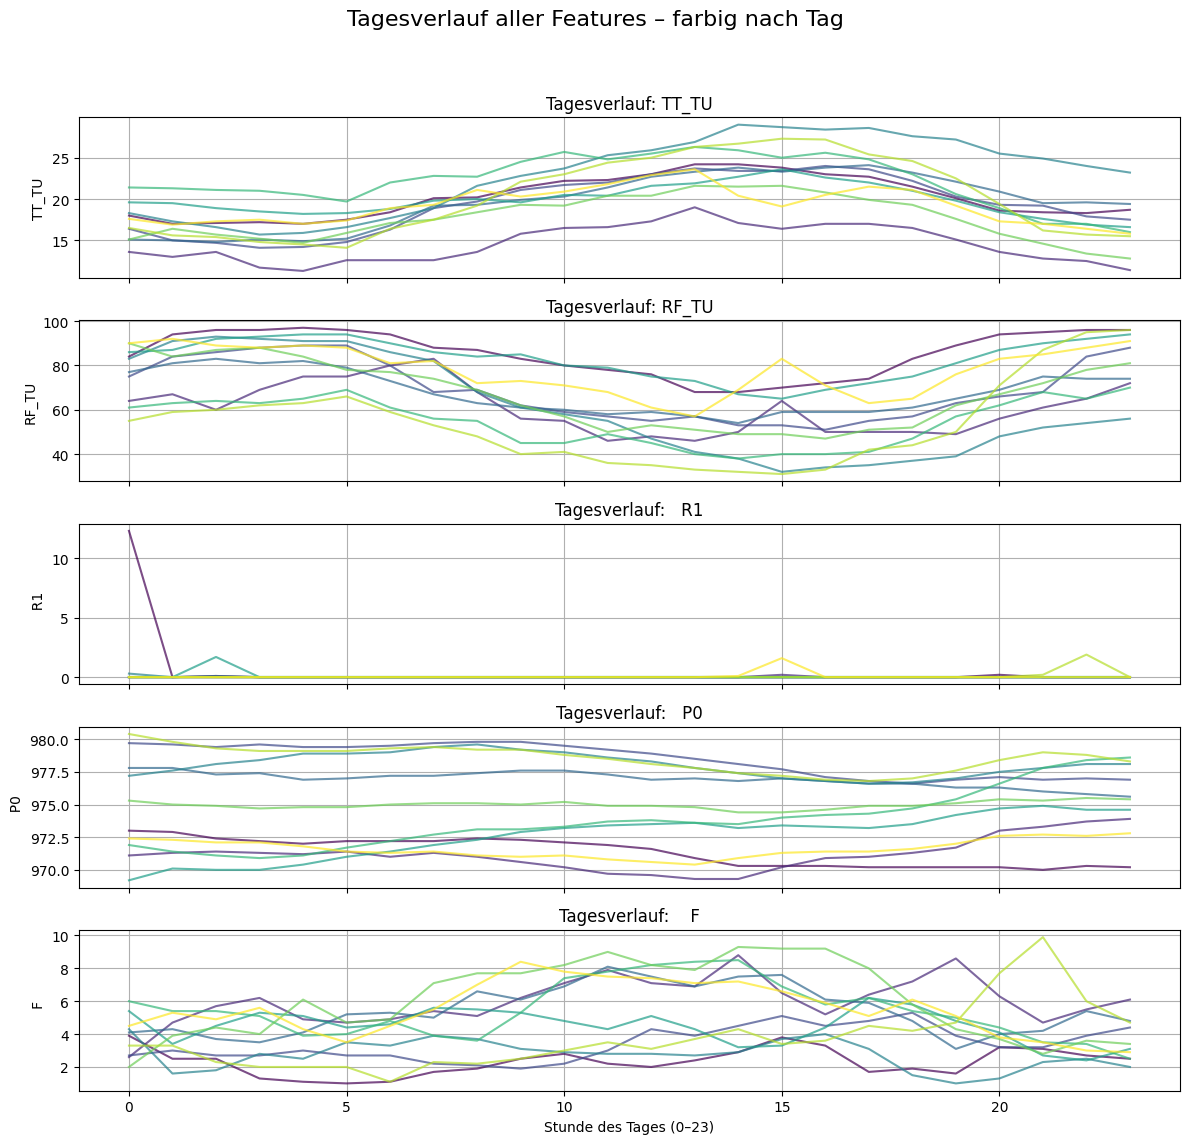

In [135]:
colors = cm.viridis(np.linspace(0, 1, nYears))

fig, axs = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

for i, target in enumerate(targets):
    for day_id, (day, group) in enumerate(real_df.groupby('Year')):
        axs[i].plot(group['hour'], group[target], color=colors[day_id], alpha=0.7)
    
    axs[i].set_ylabel(target)
    axs[i].set_title(f"Tagesverlauf: {target}")
    axs[i].grid(True)

axs[-1].set_xlabel("Stunde des Tages (0–23)")
plt.suptitle("Tagesverlauf aller Features – farbig nach Tag", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [136]:
print(fake_df)
fake_df['Year'] = np.tile(np.arange(nYears), hoursPerDay)

fake_df = fake_df.sort_values(by=['Year', 'hour']).reset_index(drop=True)

        TT_TU       RF_TU        R1          P0         F  Stationshoehe  \
0   -3.287877   90.578843  0.029876  966.508638  1.745642          316.0   
1    3.272185   86.743986  0.330062  970.619827  1.755552          316.0   
2   -3.642886   92.391232  0.217281  953.353971  2.847035          316.0   
3   -8.014708   85.761335  0.418954  967.893306  3.836618          316.0   
4   -0.052334   92.514307 -0.118166  978.053686  4.740736          316.0   
..        ...         ...       ...         ...       ...            ...   
235 -3.073682   97.804610  0.679406  957.394369  1.081953          316.0   
236  1.236086   88.154076  0.073024  955.364834  3.695054          316.0   
237  0.286036  103.726677  0.546283  965.668639 -0.309842          316.0   
238 -5.425911   87.267799  0.049142  961.484283  0.077619          316.0   
239  1.896613   90.862661  0.138926  963.277188  2.090866          316.0   

     geoBreite  geoLaenge  hour     month  day_of_year  
0      50.9829    10.9608   0.

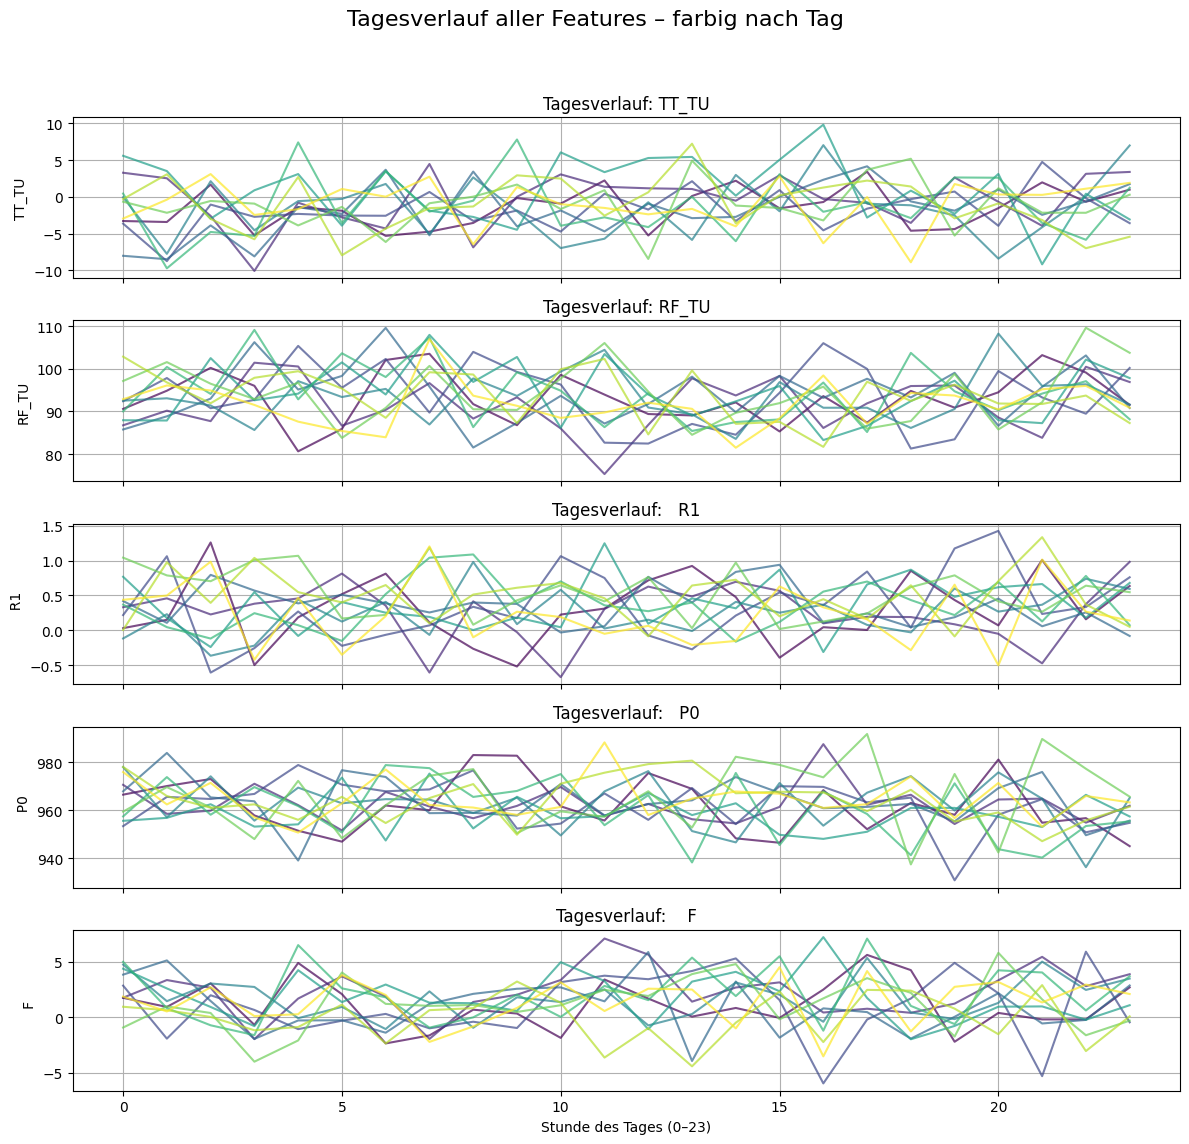

In [137]:
colors = cm.viridis(np.linspace(0, 1, nYears))

fig, axs = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

for i, target in enumerate(targets):
    for day_id, (day, group) in enumerate(fake_df.groupby('Year')):
        axs[i].plot(group['hour'], group[target], color=colors[day_id], alpha=0.7)
    
    axs[i].set_ylabel(target)
    axs[i].set_title(f"Tagesverlauf: {target}")
    axs[i].grid(True)

axs[-1].set_xlabel("Stunde des Tages (0–23)")
plt.suptitle("Tagesverlauf aller Features – farbig nach Tag", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [138]:
dfScaled= pd.DataFrame(xScaled, columns= dataCol)
synDf= pd.DataFrame(samples, columns= dataCol)

In [139]:
linearModels= OLSRegression(['TT_TU', 'RF_TU', '  R1', '  P0', '   F'], dataCol, dfScaled, synDf)

Real Target: TT_TU - MSE: 0.21333908093020804
Synthetic Target: TT_TU - MSE: 4.58592604663401
Real Target: RF_TU - MSE: 0.451751758801214
Synthetic Target: RF_TU - MSE: 0.8351794420088817
Real Target: R1 - MSE: 0.9862544769312943
Synthetic Target: R1 - MSE: 0.739651400467346
Real Target: P0 - MSE: 0.08330620620023495
Synthetic Target: P0 - MSE: 0.45517564293204354
Real Target: F - MSE: 0.7603637974980307
Synthetic Target: F - MSE: 1.1823616383801847


In [140]:
#PCA Analyse und Visualisierung

In [141]:
nComponents= 2
size= 1000

In [142]:
pca= PCA(n_components= nComponents)
XPca= pca.fit_transform(xScaled)

meansPca= pca.transform(gmm.means_)

probs= gmm.predict_proba(xScaled)
labels= np.argmax(probs, axis=1)

explainedVar = pca.explained_variance_ratio_
totalExplained = explainedVar.sum()

print(f"Erklärte Varianz durch die ersten 2 Komponenten: {totalExplained * 100:.2f}%")

Erklärte Varianz durch die ersten 2 Komponenten: 38.91%


In [143]:
idx= np.random.choice(len(XPca), size= size, replace= False)
XPcaSample= XPca[idx]
labelsSample= labels[idx]

C:\Users\johan\AppData\Local\Temp\ipykernel_19024\3885323640.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap= plt.cm.get_cmap('tab20', nCluster)


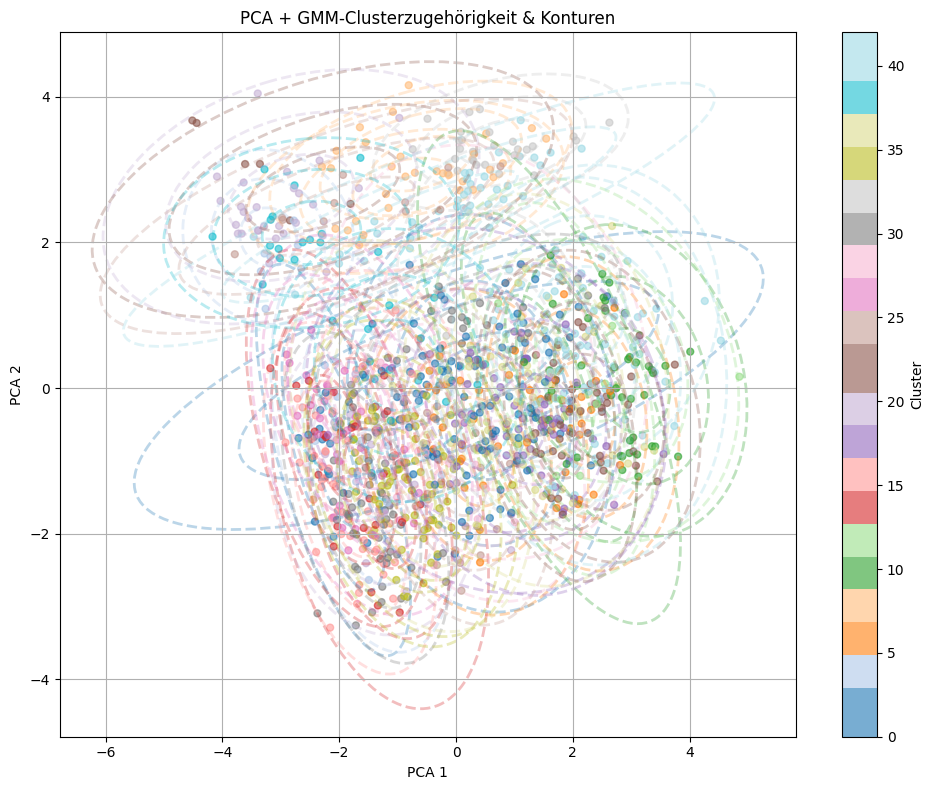

In [144]:
fig, ax= plt.subplots(figsize=(10, 8))

nCluster= len(meansPca)
cmap= plt.cm.get_cmap('tab20', nCluster)

# Scatterpunkte farblich nach Cluster
scatter= ax.scatter(XPcaSample[:, 0], XPcaSample[:, 1],
                     c= labelsSample, cmap= cmap, alpha= 0.6, s= 25)

# Ellipsen pro Cluster
for i in range(nCluster):
    cov= gmm.covariances_[i]
    covPca= pca.components_ @ cov @ pca.components_.T

    if covPca.shape == (2, 2):
        U, s, Vt= np.linalg.svd(covPca)
        angle= np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height= 2 * np.sqrt(s)
    else:
        angle= 0
        width, height= 2 * np.sqrt(covPca)

    for nsig in range(1, 4):
        ell_color= cmap(i)
        kwargs= {
            'alpha': 0.3,
            'facecolor': 'none',
            'edgecolor': ell_color,
            'linestyle': '--',
            'linewidth': 2
        }
        ell = Ellipse(xy= meansPca[i], width= nsig*width, height= nsig*height, angle= angle, **kwargs)
        ax.add_patch(ell)

# Achsen & Legende
ax.set_title("PCA + GMM-Clusterzugehörigkeit & Konturen")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
plt.colorbar(scatter, ax=ax, label="Cluster")
ax.grid(True)
plt.tight_layout()
plt.show()

In [145]:
nComponents= 5
size= 1000

In [146]:
pca= PCA(n_components= nComponents)
XPca= pca.fit_transform(xScaled)

meansPca= pca.transform(gmm.means_)

probs= gmm.predict_proba(xScaled)
labels= np.argmax(probs, axis=1)

explainedVar = pca.explained_variance_ratio_
totalExplained = explainedVar.sum()

print(f"Erklärte Varianz durch die ersten 2 Komponenten: {totalExplained * 100:.2f}%")

Erklärte Varianz durch die ersten 2 Komponenten: 72.44%


In [147]:
idx= np.random.choice(len(XPca), size= size, replace= False)
XPcaSample= XPca[idx]
labelsSample= labels[idx]

C:\Users\johan\AppData\Local\Temp\ipykernel_19024\1497849129.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', nClusters)


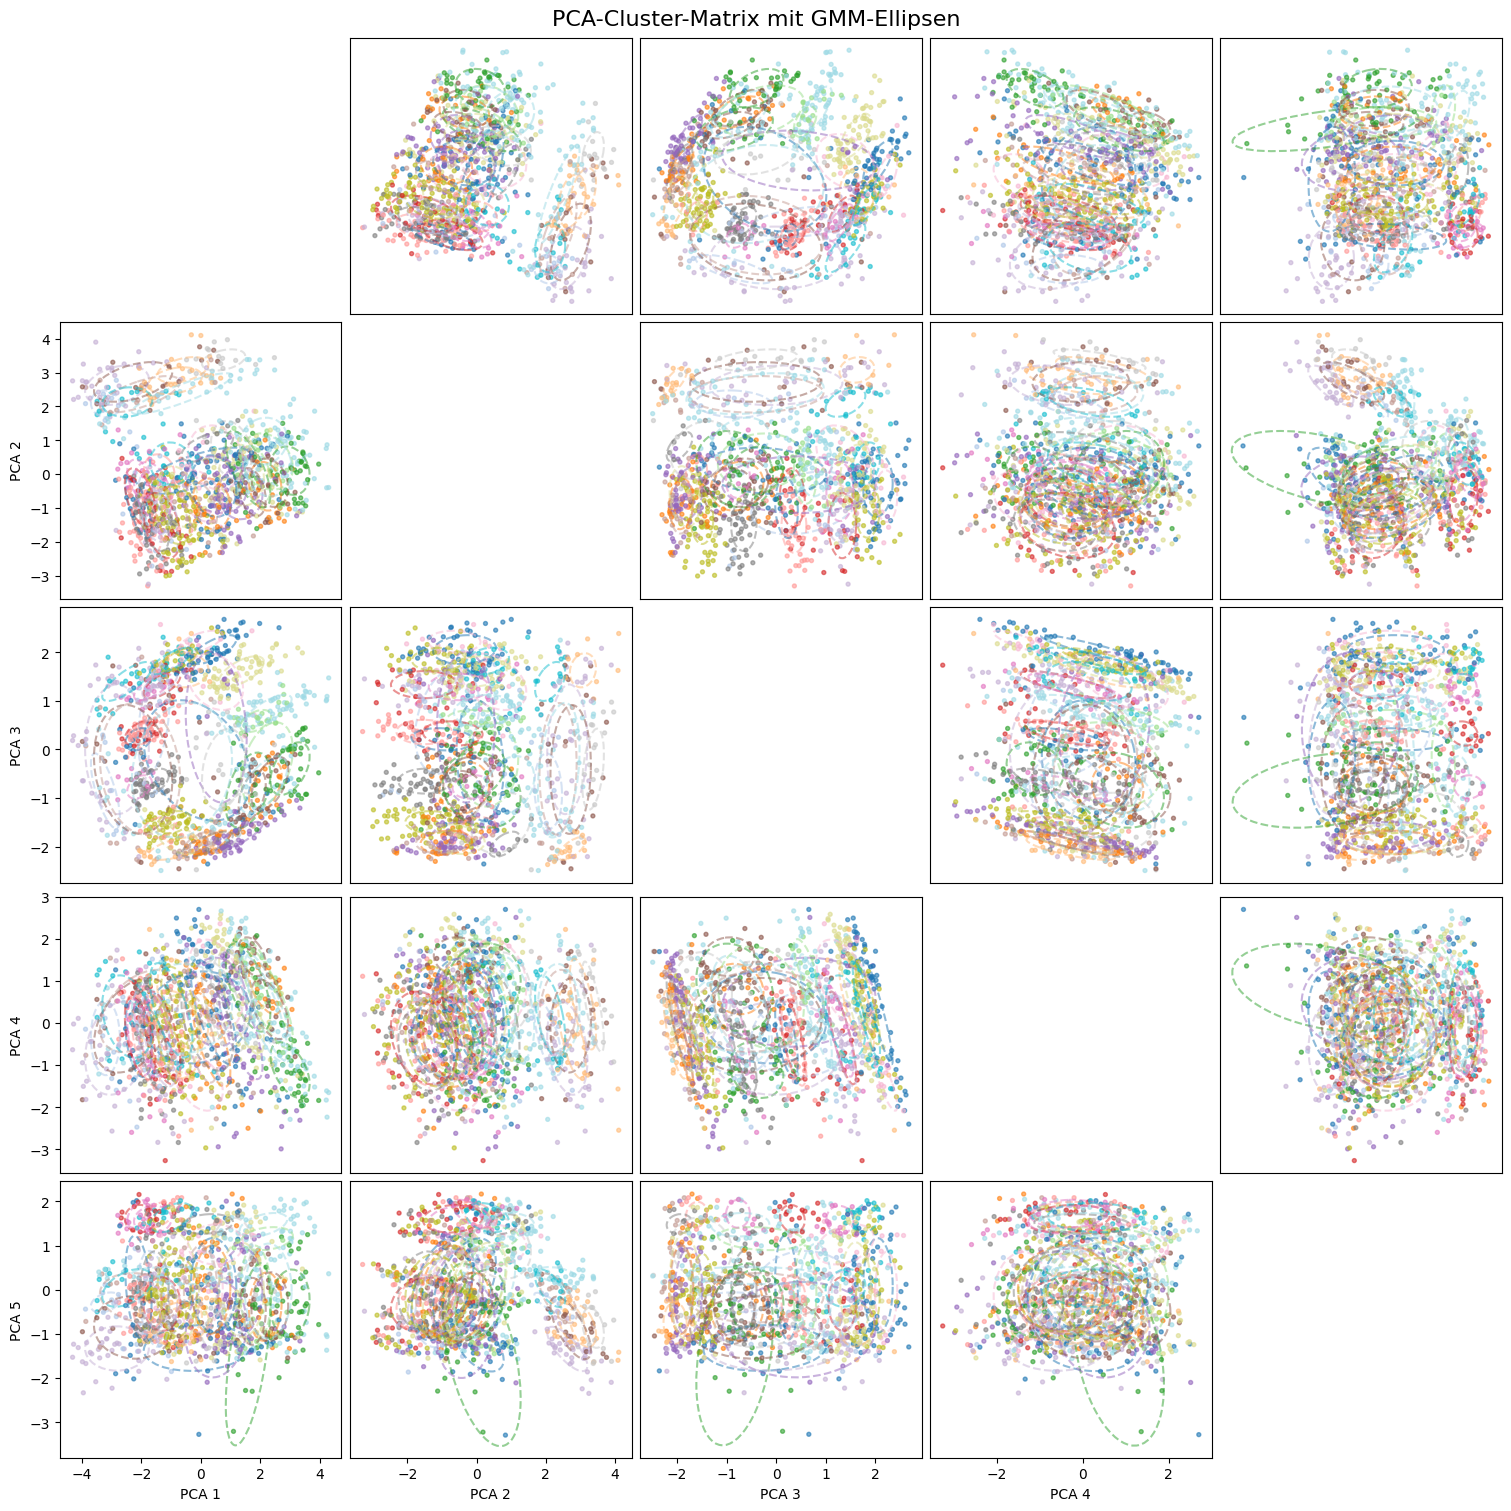

In [148]:
plot_pca_cluster_matrix(XPcaSample, labelsSample, gmm, pca, nComponents=nComponents, sample_size= 1000)

In [149]:
#Echte Feature Scattermatrix

In [150]:
probs= gmm.predict_proba(xScaled)
labels= np.argmax(probs, axis=1)

In [151]:
realCyclic_df = pd.DataFrame(scaler.inverse_transform(xScaled), columns= dataCol)

In [152]:
real_df= inverse_cyclical(realCyclic_df)

C:\Users\johan\AppData\Local\Temp\ipykernel_19024\2306686914.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", n_clusters)


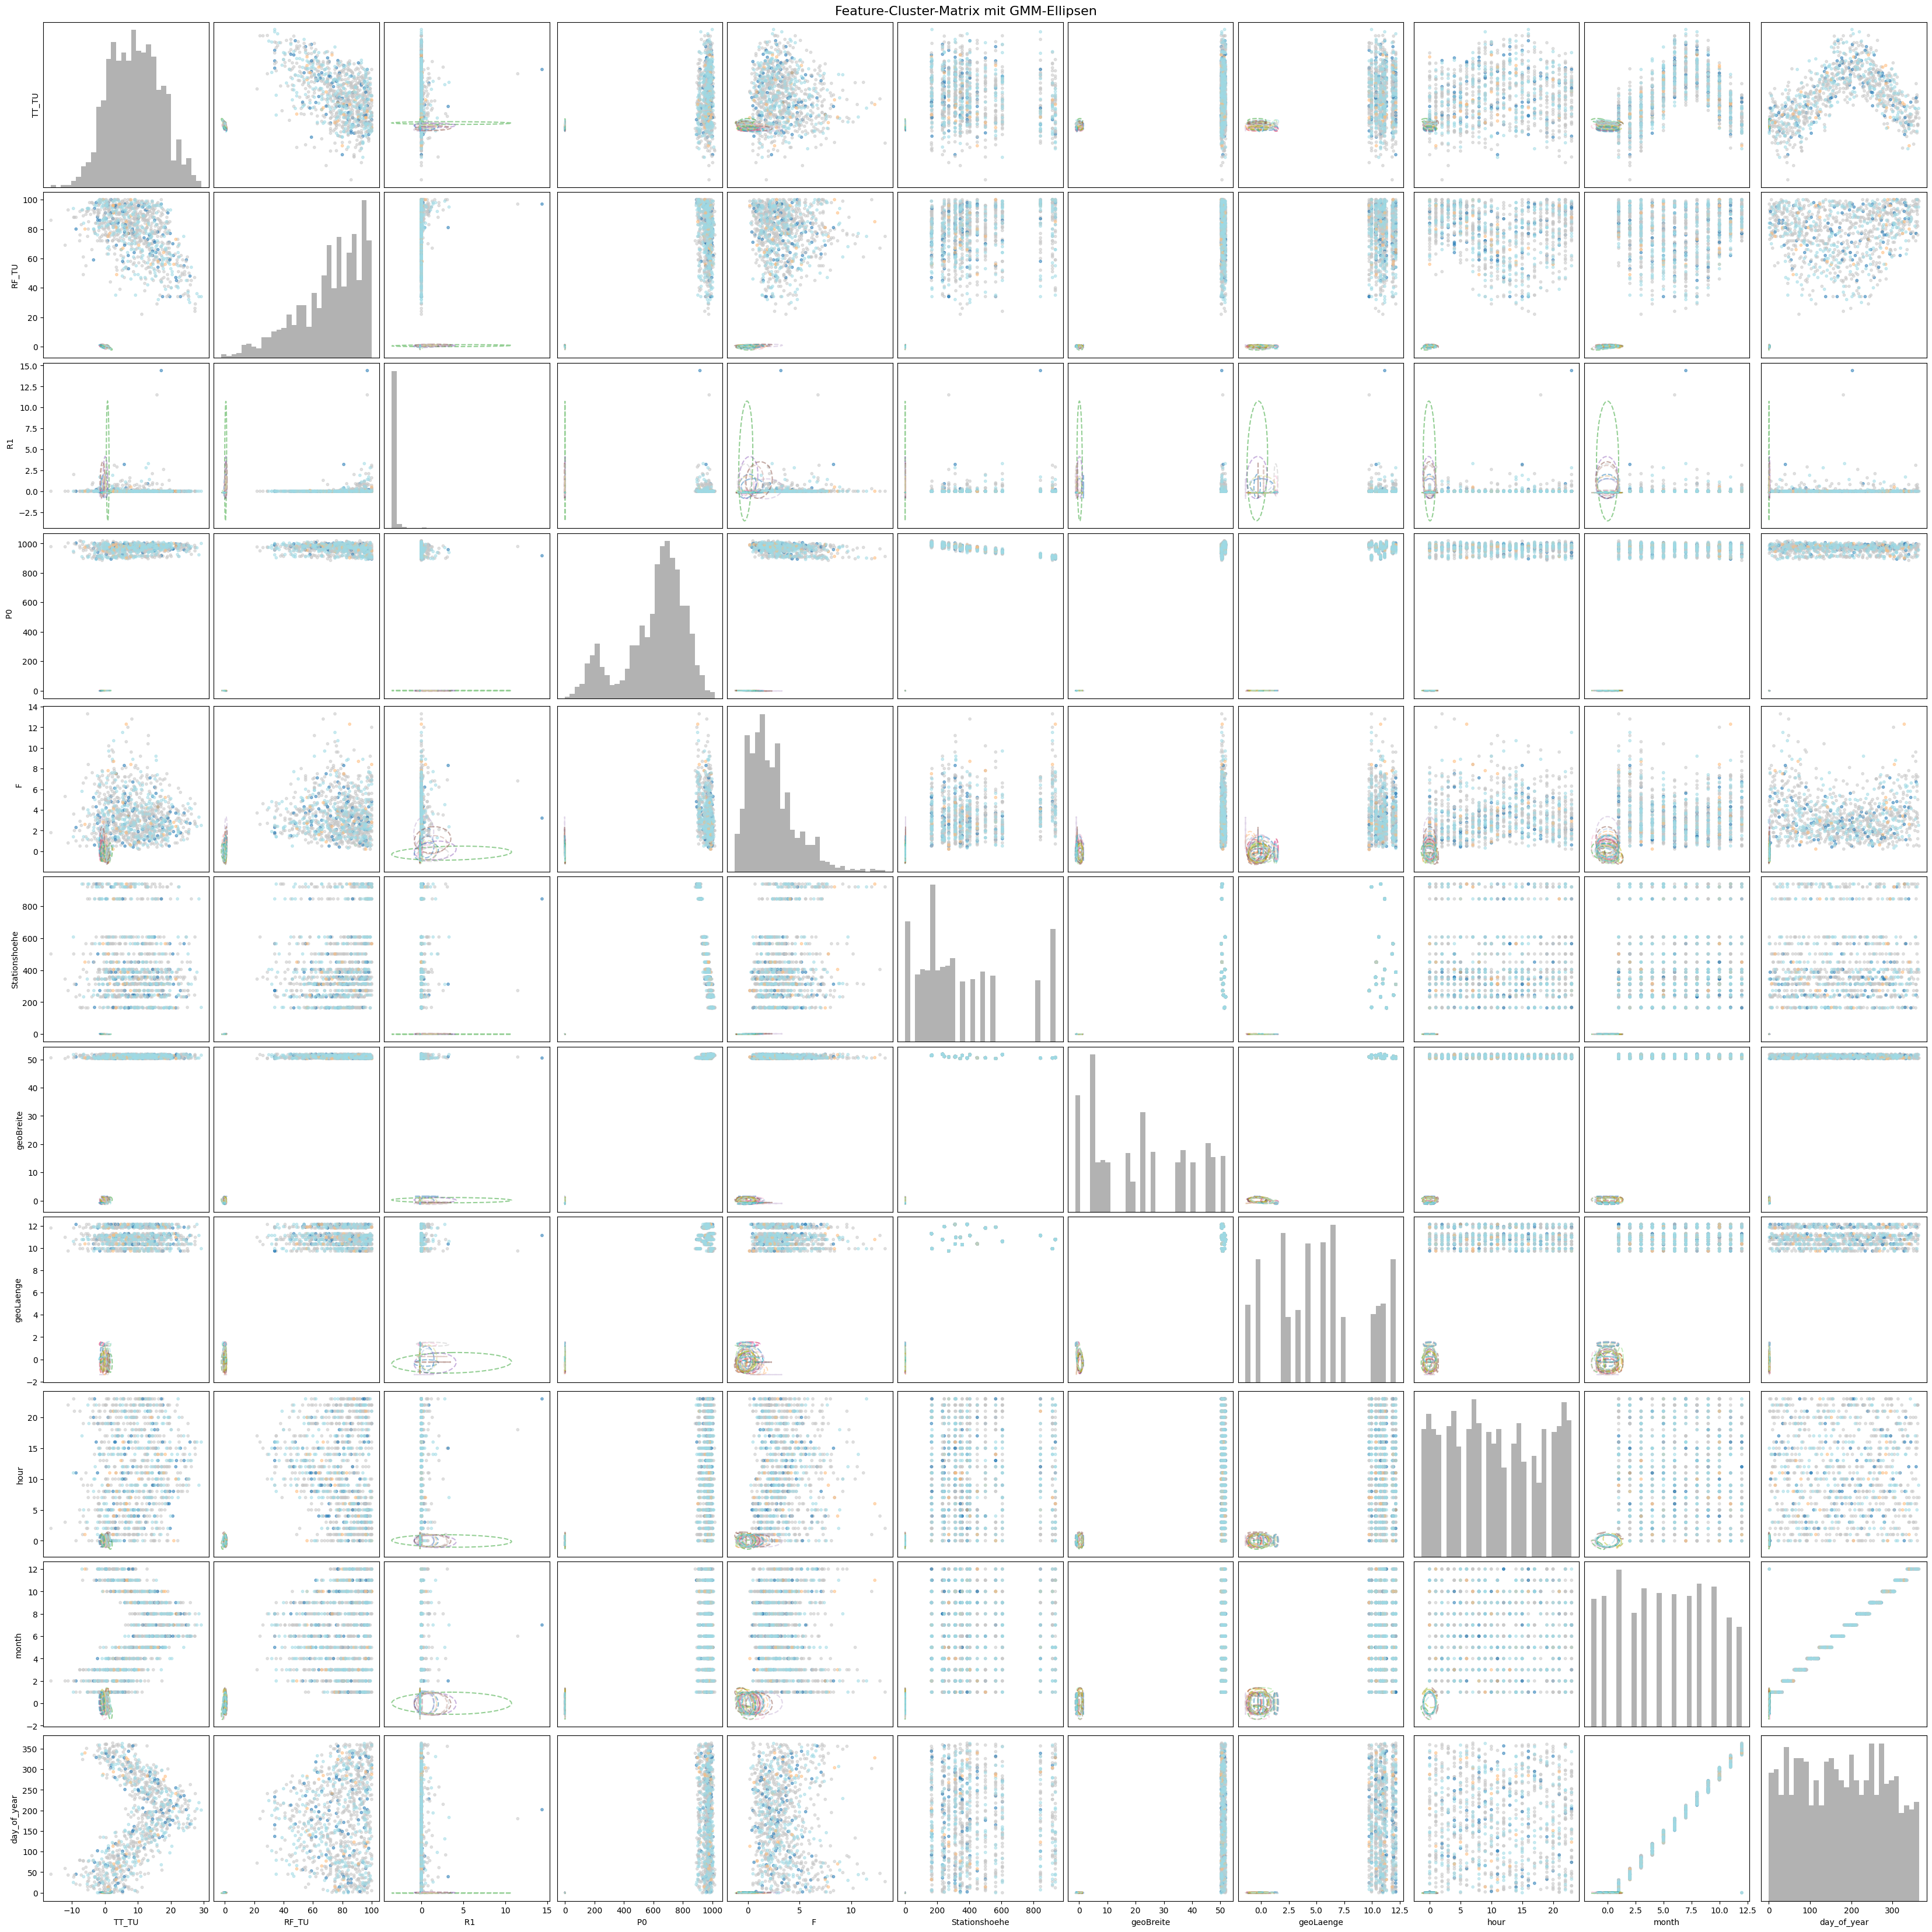

In [153]:
plot_feature_cluster_matrix(real_df, labels, gmm, sample_size= 1000)

In [154]:
#QDA Cluster splitability

In [155]:
labels = np.argmax(gmm.predict_proba(xScaled), axis=1)

In [156]:
XTrain, XTest, yTrain, yTest = train_test_split(xScaled, labels, stratify=labels, random_state=42)
qda = QuadraticDiscriminantAnalysis(reg_param=0.01)
qda.fit(XTrain, yTrain)

QuadraticDiscriminantAnalysis(reg_param=0.01)

In [157]:
yPred = qda.predict(XTest)
print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     10275
           1       1.00      0.62      0.77      4154
           2       0.96      1.00      0.98     26177
           3       0.91      0.99      0.95      3719
           4       0.98      0.62      0.76      7326
           5       0.94      0.98      0.96     11616
           6       0.96      1.00      0.98      6190
           7       0.96      1.00      0.98      6234
           8       0.96      1.00      0.98      6466
           9       0.98      0.99      0.99     15504
          10       0.95      0.65      0.77      3860
          11       0.73      0.46      0.57      1222
          12       0.96      1.00      0.98      5439
          13       0.82      0.99      0.90      6051
          14       0.92      1.00      0.96      7897
          15       0.95      1.00      0.97     17146
          16       0.92      1.00      0.96      4661
          17       0.95    

In [158]:
# LDA real vs. synthetic

In [159]:
sampleSize= 10000

if len(xScaled) > sampleSize:
    sample_idx = np.random.choice(len(xScaled), size=sampleSize, replace=False)
    xScaledSampled = xScaled[sample_idx]
else:
    xScaledSampled = xScaled

samples, _ = gmm.sample(sampleSize)
samplesOriginal = scaler.inverse_transform(samples)

In [160]:
XCombined = np.vstack([xScaledSampled, samples])
yCombined = np.hstack([
    np.zeros(len(xScaledSampled)),     # Label 0 = echt
    np.ones(len(samples))  # Label 1 = synthetisch
])

In [161]:
XTrain, XTest, yTrain, yTest= train_test_split(XCombined, yCombined, test_size=0.2, random_state=42)

In [162]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(XTrain, yTrain)

QuadraticDiscriminantAnalysis()

In [163]:
y_pred = qda.predict(XTest)
acc = accuracy_score(yTest, y_pred)

print(f"QDA Accuracy (real vs synthetic): {acc:.2%}")

QDA Accuracy (real vs synthetic): 49.65%


In [164]:
# QDA real vs. synthetic

In [165]:
sampleSize= 1000

samples, _ = gmm.sample(sampleSize)
samplesOriginal = scaler.inverse_transform(samples)

if len(xScaled) > sampleSize:
    sample_idx = np.random.choice(len(xScaled), size=sampleSize, replace=False)
    xScaledSampled = xScaled[sample_idx]
else:
    xScaledSampled = xScaled

In [166]:
XCombined = np.vstack([xScaledSampled, samples])
yCombined = np.hstack([
    np.zeros(len(xScaledSampled)),     # Label 0 = echt
    np.ones(len(samples))  # Label 1 = synthetisch
])

In [167]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(XCombined, yCombined)

QuadraticDiscriminantAnalysis()

In [168]:
y_pred = qda.predict(XCombined)
acc = accuracy_score(yCombined, y_pred) 

print(f"QDA Accuracy (real vs synthetic): {acc:.2%}")

QDA Accuracy (real vs synthetic): 59.35%


In [169]:
# QDA Visulisation

C:\Users\johan\AppData\Local\Temp\ipykernel_19024\939960152.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", np.unique(labels).size)


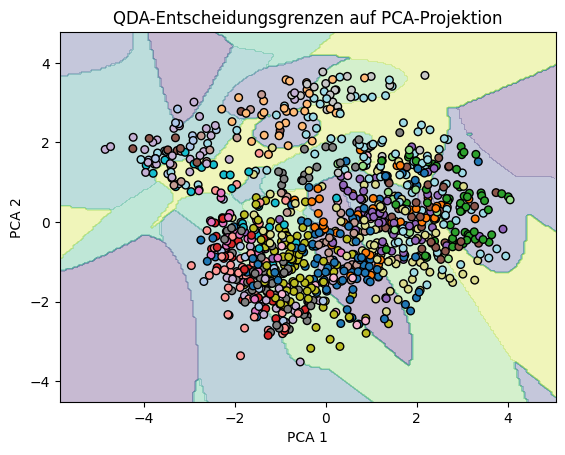

In [170]:
sampleSize = 1000
if len(xScaled) > sampleSize:
    sample_idx = np.random.choice(len(xScaled), size=sampleSize, replace=False)
    xScaledSampled = xScaled[sample_idx]
else:
    xScaledSampled = xScaled

# PCA für Visualisierung
pca = PCA(n_components=2)
XPca = pca.fit_transform(xScaledSampled)
labels = np.argmax(gmm.predict_proba(xScaledSampled), axis=1)

# QDA im 2D-Raum
qda = QuadraticDiscriminantAnalysis()
qda.fit(XPca, labels)

# Meshgrid zur Visualisierung
x_min, x_max = XPca[:, 0].min() - 1, XPca[:, 0].max() + 1
y_min, y_max = XPca[:, 1].min() - 1, XPca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cmap = plt.cm.get_cmap("tab20", np.unique(labels).size)
# Plot
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(XPca[:, 0], XPca[:, 1], c=labels, cmap=cmap, edgecolor='k', s=30)
plt.title("QDA-Entscheidungsgrenzen auf PCA-Projektion")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


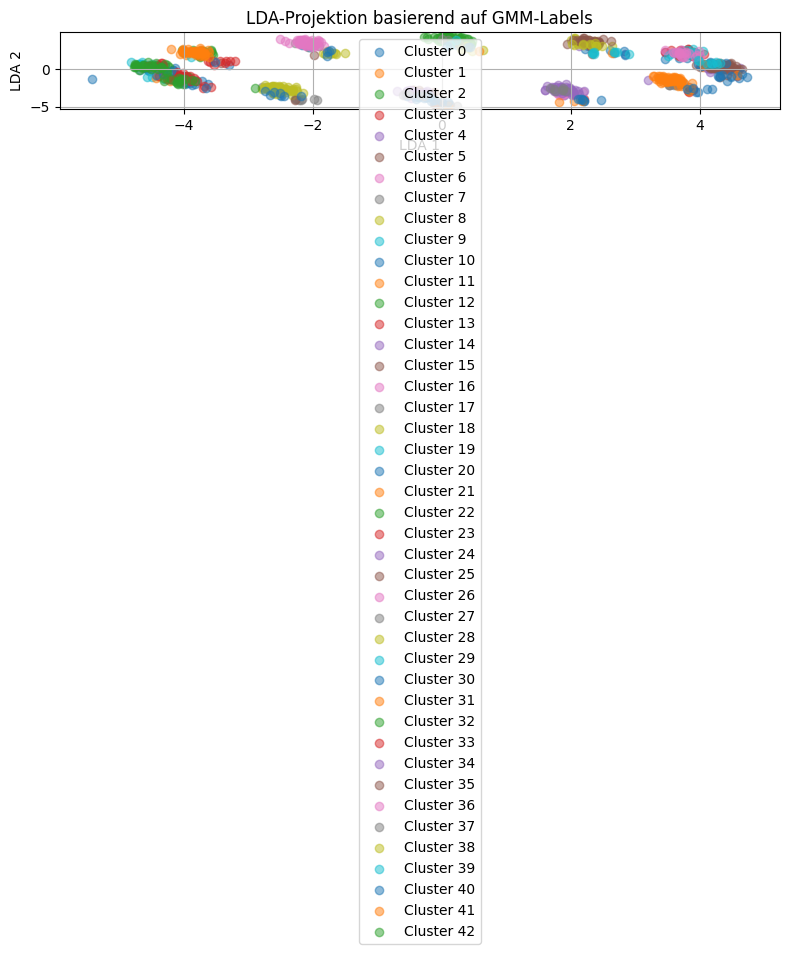

In [171]:
sampleSize = 1000
if len(xScaled) > sampleSize:
    sample_idx = np.random.choice(len(xScaled), size=sampleSize, replace=False)
    xScaledSampled = xScaled[sample_idx]
else:
    xScaledSampled = xScaled

labels = np.argmax(gmm.predict_proba(xScaledSampled), axis=1)
lda = LinearDiscriminantAnalysis(n_components=2)
Xlda = lda.fit_transform(xScaledSampled, labels)

plt.figure(figsize=(8, 6))
for cluster in np.unique(labels):
    plt.scatter(Xlda[labels == cluster, 0], Xlda[labels == cluster, 1], label=f"Cluster {cluster}", alpha=0.5)
plt.title("LDA-Projektion basierend auf GMM-Labels")
plt.xlabel("LDA 1")
plt.ylabel("LDA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Daywise Analysis

In [ ]:
daywiseDfOriginal = pd.read_pickle("..\\data\\daywiseDf.pkl")

model_bundle1 = joblib.load("../data/dayWiseModel/gmm_7_model.pkl")
model_bundle2 = joblib.load("../data/dayWiseModel/gmm_11_model.pkl")
scaler1 = model_bundle1['scaler']
scaler2 = model_bundle2['scaler']
gmm1 = model_bundle1['gmm']
gmm2 = model_bundle2['gmm']

cyclical= {'month': 12, 'day_of_year': 365}

In [ ]:
daywiseDfOriginal.columns

In [ ]:
df= daywiseDfOriginal.drop(columns= ['STATIONS_ID','RS_IND_00','RS_IND_01','RS_IND_02','RS_IND_03','RS_IND_04','RS_IND_05','RS_IND_06','RS_IND_07','RS_IND_08','RS_IND_09','RS_IND_10','RS_IND_11','RS_IND_12','RS_IND_13','RS_IND_14','RS_IND_15','RS_IND_16','RS_IND_17','RS_IND_18','RS_IND_19','RS_IND_20','RS_IND_21','RS_IND_22','RS_IND_23','WRTR_00','WRTR_01','WRTR_02','WRTR_03','WRTR_04','WRTR_05','WRTR_06','WRTR_07','WRTR_08','WRTR_09','WRTR_10','WRTR_11','WRTR_12','WRTR_13','WRTR_14', 'WRTR_15', 'WRTR_16', 'WRTR_17', 'WRTR_18', 'WRTR_19', 'WRTR_20', 'WRTR_21', 'WRTR_22', 'WRTR_23','   P_00','   P_01','   P_02','   P_03','   P_04','   P_05','   P_06','   P_07','   P_08','   P_09','   P_10','   P_11','   P_12','   P_13','   P_14','   P_15','   P_16','   P_17','   P_18','   P_19','   P_20','   P_21','   P_22','   P_23','   D_00','   D_01', '   D_02','   D_03','   D_04','   D_05','   D_06','   D_07','   D_08','   D_09','   D_10','   D_11','   D_12','   D_13','   D_14','   D_15','   D_16','   D_17','   D_18','   D_19','   D_20','   D_21','   D_22','   D_23','Stationsname', 'day', 'month'])

In [ ]:
dataCol= df.columns

In [ ]:
X = df.values

In [ ]:
xScaled1= scaler1.transform(X)
xScaled2= scaler2.transform(X)

In [ ]:
df.columns

In [ ]:
features= dataCol
tmp= ['TT_TU', 'RF_TU', '  R1', '  P0', '   F']
targets= [f"{feature}_{i:02d}" for feature in tmp for i in range(24)]

In [ ]:
samples1, _ = gmm1.sample(1000)
samplesOriginal1 = scaler1.inverse_transform(samples1)

samples2, _ = gmm2.sample(1000)
samplesOriginal2 = scaler2.inverse_transform(samples2)

In [ ]:
realCyclic_df = pd.DataFrame(X, columns= dataCol)

fakeCyclic_df1 = pd.DataFrame(samplesOriginal1, columns= dataCol)
fakeCyclic_df2 = pd.DataFrame(samplesOriginal2, columns= dataCol)

In [ ]:
fake_df1= inverse_cyclical(fakeCyclic_df1, cyclical= cyclical)
fake_df2= inverse_cyclical(fakeCyclic_df2, cyclical= cyclical)

real_df= inverse_cyclical(realCyclic_df, cyclical= cyclical)

In [ ]:
comparison = pd.DataFrame({
    'mean_real': real_df.mean(),
    'mean_fake': fake_df1.mean(),
    'std_real': real_df.std(),
    'std_fake': fake_df1.std(),
    'max_real': real_df.max(),
    'max_fake': fake_df1.max(),
    'min_real': real_df.min(),
    'min_fake': fake_df1.min()
})
print(comparison)

In [ ]:
comparison = pd.DataFrame({
    'mean_real': real_df.mean(),
    'mean_fake': fake_df2.mean(),
    'std_real': real_df.std(),
    'std_fake': fake_df2.std(),
    'max_real': real_df.max(),
    'max_fake': fake_df2.max(),
    'min_real': real_df.min(),
    'min_fake': fake_df2.min()
})
print(comparison)

In [ ]:
dfScaled= pd.DataFrame(xScaled1, columns= dataCol)

synDf1= pd.DataFrame(samples1, columns= dataCol)
synDf2= pd.DataFrame(samples2, columns= dataCol)

In [ ]:
linearModels1= OLSRegression(targets, dataCol, dfScaled, synDf1)

In [ ]:
linearModels2= OLSRegression(targets, dataCol, dfScaled, synDf2)

In [ ]:
#Location Conditional Evaluation Day

In [ ]:
#Linear Regression Targets and Features
features= dataCol
tmp= ['TT_TU', 'RF_TU', '  R1', '  P0', '   F']
targets= [f"{feature}_{i:02d}" for feature in tmp for i in range(24)]

#Conditional Generation
nSamples= 1000
condValues= [316, 50.9829, 10.9608]
idxCond= [0, 1, 2]

In [ ]:
samples1= conditionalSampleGeneration(gmm1, condValues, idxCond, dataCol, scaler1, nSamples)
samples2= conditionalSampleGeneration(gmm2, condValues, idxCond, dataCol, scaler2, nSamples)

In [ ]:
samplesOriginal1 = scaler1.inverse_transform(samples1)
samplesOriginal2 = scaler2.inverse_transform(samples2)

In [ ]:
tmp = pd.DataFrame(X, columns= dataCol)
realCyclic_df = tmp[(tmp['Stationshoehe'] == condValues[0]) & (tmp['geoBreite'].sub(condValues[1]).abs() < 1e-4) & (tmp['geoLaenge'].sub(condValues[2]).abs() < 1e-4)]

fakeCyclic_df1 = pd.DataFrame(samplesOriginal1, columns= dataCol)
fakeCyclic_df2 = pd.DataFrame(samplesOriginal2, columns= dataCol)

In [ ]:
fake_df1= inverse_cyclical(fakeCyclic_df1, cyclical= cyclical)
fake_df2= inverse_cyclical(fakeCyclic_df2, cyclical= cyclical)

real_df= inverse_cyclical(realCyclic_df, cyclical= cyclical)

In [ ]:
comparison = pd.DataFrame({
    'mean_real': real_df.mean(),
    'mean_fake': fake_df1.mean(),
    'std_real': real_df.std(),
    'std_fake': fake_df1.std(),
    'max_real': real_df.max(),
    'max_fake': fake_df1.max(),
    'min_real': real_df.min(),
    'min_fake': fake_df1.min()
})

print(comparison)

In [ ]:
comparison = pd.DataFrame({
    'mean_real': real_df.mean(),
    'mean_fake': fake_df2.mean(),
    'std_real': real_df.std(),
    'std_fake': fake_df2.std(),
    'max_real': real_df.max(),
    'max_fake': fake_df2.max(),
    'min_real': real_df.min(),
    'min_fake': fake_df2.min()
})

print(comparison)

In [ ]:
dfScaled= pd.DataFrame(xScaled1, columns= dataCol)

synDf1= pd.DataFrame(samples1, columns= dataCol)
synDf2= pd.DataFrame(samples2, columns= dataCol)

In [ ]:
linearModels1= OLSRegression(targets, dataCol, dfScaled, synDf1)

In [ ]:
linearModels2= OLSRegression(targets, dataCol, dfScaled, synDf2)

In [ ]:
#Timesieres Evaluation (Temporal Conditional Evaluation) Day

In [ ]:
#Linear Regression Targets and Features
features= dataCol
tmpfeatures= ['TT_TU', 'RF_TU', '  R1', '  P0', '   F']
targets= [f"{feature}_{i:02d}" for feature in tmpfeatures for i in range(24)]

# Conditional Temporal Generation
nSamples= 10
condValues= [316, 50.9829, 10.9608, np.sin(2 * np.pi * 7 / 12), np.cos(2 * np.pi * 7 / 12), np.sin(2 * np.pi * 210 / 365), np.cos(2 * np.pi * 210 / 365)]
idxCond= [0, 1, 2, 3, 4, 5, 6]

nYears = 10

In [ ]:
samples1= conditionalSampleGeneration(gmm1, condValues, idxCond, dataCol, scaler1, nSamples)
samples2= conditionalSampleGeneration(gmm2, condValues, idxCond, dataCol, scaler2, nSamples)

In [ ]:
samplesOriginal1 = scaler1.inverse_transform(samples1)
samplesOriginal2 = scaler2.inverse_transform(samples2)

In [ ]:
tmp = pd.DataFrame(X, columns= dataCol)
realCyclic_df = tmp[(tmp['Stationshoehe'] == condValues[0]) & (tmp['geoBreite'].sub(condValues[1]).abs() < 1e-4) & (tmp['geoLaenge'].sub(condValues[2]).abs() < 1e-4) & (tmp['month_sin'].sub(condValues[3]).abs() < 1e-4) & (tmp['month_cos'].sub(condValues[4]).abs() < 1e-4) & (tmp['day_of_year_sin'].sub(condValues[5]).abs() < 1e-4)  & (tmp['day_of_year_cos'].sub(condValues[6]).abs() < 1e-4)]

fakeCyclic_df1 = pd.DataFrame(samplesOriginal1, columns= dataCol)
fakeCyclic_df2 = pd.DataFrame(samplesOriginal2, columns= dataCol)

In [ ]:
fake_df1= inverse_cyclical(fakeCyclic_df1, cyclical= cyclical)
fake_df2= inverse_cyclical(fakeCyclic_df2, cyclical= cyclical)

real_df= inverse_cyclical(realCyclic_df, cyclical= cyclical)

In [ ]:
comparison = pd.DataFrame({
    'mean_real': real_df.mean(),
    'mean_fake': fake_df1.mean(),
    'std_real': real_df.std(),
    'std_fake': fake_df1.std(),
    'max_real': real_df.max(),
    'max_fake': fake_df1.max(),
    'min_real': real_df.min(),
    'min_fake': fake_df1.min()
})

print(comparison)

In [ ]:
comparison = pd.DataFrame({
    'mean_real': real_df.mean(),
    'mean_fake': fake_df2.mean(),
    'std_real': real_df.std(),
    'std_fake': fake_df2.std(),
    'max_real': real_df.max(),
    'max_fake': fake_df2.max(),
    'min_real': real_df.min(),
    'min_fake': fake_df2.min()
})

print(comparison)

In [ ]:
colors = cm.viridis(np.linspace(0, 1, len(real_df)))

fig, axs = plt.subplots(len(tmpfeatures), 1, figsize=(12, 12), sharex=True)

for i, feature in enumerate(tmpfeatures):
    feature_cols = [f"{feature}_{h:02d}" for h in range(24)]
    data = real_df[feature_cols].values  # shape: (n_samples, 24)

    for row_idx in range(data.shape[0]):
        axs[i].plot(range(24), data[row_idx], color=colors[row_idx], alpha=0.8)

    axs[i].set_ylabel(feature.strip())
    axs[i].set_title(f"Tagesverlauf: {feature.strip()}")
    axs[i].grid(True)

axs[-1].set_xlabel("Stunde des Tages (0–23)")
plt.suptitle("Tagesverlauf aller Features – farbig nach Jahr", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
colors = cm.viridis(np.linspace(0, 1, len(fake_df1)))

fig, axs = plt.subplots(len(tmpfeatures), 1, figsize=(12, 12), sharex=True)

for i, feature in enumerate(tmpfeatures):
    feature_cols = [f"{feature}_{h:02d}" for h in range(24)]
    data = fake_df1[feature_cols].values  # shape: (n_samples, 24)

    for row_idx in range(data.shape[0]):
        axs[i].plot(range(24), data[row_idx], color=colors[row_idx], alpha=0.8)

    axs[i].set_ylabel(feature.strip())
    axs[i].set_title(f"Tagesverlauf: {feature.strip()}")
    axs[i].grid(True)

axs[-1].set_xlabel("Stunde des Tages (0–23)")
plt.suptitle("Tagesverlauf aller Features – farbig nach Jahr", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
colors = cm.viridis(np.linspace(0, 1, len(fake_df2)))

fig, axs = plt.subplots(len(tmpfeatures), 1, figsize=(12, 12), sharex=True)

for i, feature in enumerate(tmpfeatures):
    feature_cols = [f"{feature}_{h:02d}" for h in range(24)]
    data = fake_df2[feature_cols].values  # shape: (n_samples, 24)

    for row_idx in range(data.shape[0]):
        axs[i].plot(range(24), data[row_idx], color=colors[row_idx], alpha=0.8)

    axs[i].set_ylabel(feature.strip())
    axs[i].set_title(f"Tagesverlauf: {feature.strip()}")
    axs[i].grid(True)

axs[-1].set_xlabel("Stunde des Tages (0–23)")
plt.suptitle("Tagesverlauf aller Features – farbig nach Jahr", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
dfScaled= pd.DataFrame(xScaled1, columns= dataCol)

synDf1= pd.DataFrame(samples1, columns= dataCol)
synDf2= pd.DataFrame(samples2, columns= dataCol)

In [ ]:
linearModels2= OLSRegression(targets, dataCol, dfScaled, synDf2)

In [ ]:
linearModels2= OLSRegression(targets, dataCol, dfScaled, synDf2)

In [ ]:
#PCA Analyse und Visualisierung

In [ ]:
nComponents= 2
size= 1000

In [ ]:
print(len(gmm1.means_), len(gmm2.means_))

In [ ]:
pca1= PCA(n_components= nComponents)
XPca1= pca1.fit_transform(xScaled1)

meansPca1= pca1.transform(gmm1.means_)

probs1= gmm1.predict_proba(xScaled1)
labels1= np.argmax(probs1, axis=1)

explainedVar1 = pca1.explained_variance_ratio_
totalExplained1 = explainedVar1.sum()

print(f"Erklärte Varianz durch die ersten 2 Komponenten: {totalExplained1 * 100:.2f}%")

In [ ]:
pca2= PCA(n_components= nComponents)
XPca2= pca2.fit_transform(xScaled2)

meansPca2= pca2.transform(gmm2.means_)

probs2= gmm2.predict_proba(xScaled2)
labels2= np.argmax(probs2, axis=1)

explainedVar2 = pca2.explained_variance_ratio_
totalExplained2 = explainedVar2.sum()

print(f"Erklärte Varianz durch die ersten 2 Komponenten: {totalExplained2 * 100:.2f}%")

In [ ]:
idx1= np.random.choice(len(XPca1), size= size, replace= False)
XPcaSample1= XPca1[idx1]
labelsSample1= labels1[idx1]

In [ ]:
idx2= np.random.choice(len(XPca2), size= size, replace= False)
XPcaSample2= XPca2[idx2]
labelsSample2= labels2[idx2]

In [ ]:
fig, ax= plt.subplots(figsize=(10, 8))

nCluster= len(meansPca1)
cmap= plt.cm.get_cmap('tab20', nCluster)

# Scatterpunkte farblich nach Cluster
scatter= ax.scatter(XPcaSample1[:, 0], XPcaSample1[:, 1],
                     c= labelsSample1, cmap= cmap, alpha= 0.6, s= 25)

# Ellipsen pro Cluster
for i in range(nCluster):
    cov= gmm1.covariances_[i]
    covPca= pca1.components_ @ cov @ pca1.components_.T

    if covPca.shape == (2, 2):
        U, s, Vt= np.linalg.svd(covPca)
        angle= np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height= 2 * np.sqrt(s)
    else:
        angle= 0
        width, height= 2 * np.sqrt(covPca)

    for nsig in range(1, 4):
        ell_color= cmap(i)
        kwargs= {
            'alpha': 0.3,
            'facecolor': 'none',
            'edgecolor': ell_color,
            'linestyle': '--',
            'linewidth': 2
        }
        ell = Ellipse(xy= meansPca1[i], width= nsig*width, height= nsig*height, angle= angle, **kwargs)
        ax.add_patch(ell)

# Achsen & Legende
ax.set_title("PCA + GMM-Clusterzugehörigkeit & Konturen")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
plt.colorbar(scatter, ax=ax, label="Cluster")
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax= plt.subplots(figsize=(10, 8))

nCluster= len(meansPca2)
cmap= plt.cm.get_cmap('tab20', nCluster)

# Scatterpunkte farblich nach Cluster
scatter= ax.scatter(XPcaSample2[:, 0], XPcaSample2[:, 1],
                     c= labelsSample2, cmap= cmap, alpha= 0.6, s= 25)

# Ellipsen pro Cluster
for i in range(nCluster):
    cov= gmm2.covariances_[i]
    covPca= pca2.components_ @ cov @ pca2.components_.T

    if covPca.shape == (2, 2):
        U, s, Vt= np.linalg.svd(covPca)
        angle= np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height= 2 * np.sqrt(s)
    else:
        angle= 0
        width, height= 2 * np.sqrt(covPca)

    for nsig in range(1, 4):
        ell_color= cmap(i)
        kwargs= {
            'alpha': 0.3,
            'facecolor': 'none',
            'edgecolor': ell_color,
            'linestyle': '--',
            'linewidth': 2
        }
        ell = Ellipse(xy= meansPca2[i], width= nsig*width, height= nsig*height, angle= angle, **kwargs)
        ax.add_patch(ell)

# Achsen & Legende
ax.set_title("PCA + GMM-Clusterzugehörigkeit & Konturen")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
plt.colorbar(scatter, ax=ax, label="Cluster")
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
nComponents= 5
size= 1000

In [ ]:
pca1= PCA(n_components= nComponents)
XPca1= pca1.fit_transform(xScaled1)

meansPca1= pca1.transform(gmm1.means_)

probs1= gmm1.predict_proba(xScaled1)
labels1= np.argmax(probs1, axis=1)

explainedVar1 = pca1.explained_variance_ratio_
totalExplained1 = explainedVar1.sum()

print(f"Erklärte Varianz durch die ersten 2 Komponenten: {totalExplained1 * 100:.2f}%")

In [ ]:
pca2= PCA(n_components= nComponents)
XPca2= pca2.fit_transform(xScaled2)

meansPca2= pca2.transform(gmm2.means_)

probs2= gmm2.predict_proba(xScaled2)
labels2= np.argmax(probs2, axis=1)

explainedVar2 = pca2.explained_variance_ratio_
totalExplained2 = explainedVar2.sum()

print(f"Erklärte Varianz durch die ersten 2 Komponenten: {totalExplained2 * 100:.2f}%")

In [ ]:
idx1= np.random.choice(len(XPca1), size= size, replace= False)
XPcaSample1= XPca1[idx1]
labelsSample1= labels1[idx1]

In [ ]:
idx2= np.random.choice(len(XPca2), size= size, replace= False)
XPcaSample2= XPca2[idx2]
labelsSample2= labels2[idx2]

In [ ]:
plot_pca_cluster_matrix(XPcaSample1, labelsSample1, gmm1, pca1, nComponents=nComponents, sample_size= 1000)

In [ ]:
plot_pca_cluster_matrix(XPcaSample2, labelsSample2, gmm2, pca2, nComponents=nComponents, sample_size= 1000)

In [ ]:
#LDA Day

In [ ]:
labels = np.argmax(gmm.predict_proba(xScaled), axis=1)

In [ ]:
XTrain, XTest, yTrain, yTest = train_test_split(xScaled, labels, stratify=labels, random_state=42)
qda = QuadraticDiscriminantAnalysis()
qda.fit(XTrain, yTrain)

In [ ]:
yPred = qda.predict(XTest)
print(classification_report(yTest, yPred))